# Analyse mediale Sichtbarkeit und Umfragewerte

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
from sqlalchemy import create_engine
import re
import os

In [2]:
PROJECT_DIR = os.path.dirname(os.getcwd())  # Eine Ebene nach oben vom 'scripts'-Ordner
SQL_FILE = os.path.join(PROJECT_DIR, "db.sqlite3")

In [3]:
con = sqlite3.connect(SQL_FILE)

## Wordcounts

### query and load

In [4]:
#df = pd.read_sql_query("select * from count where word='cdu' or word = 'cdu/csu' or word='merz' or word='spd'or word='scholz' or word='grünen' or word = 'habeck' or word='fdp' or word='lindner' or word='bsw' or word='wagenknecht' or word='afd' or word='weidel' ", con=con)
#df

In [5]:
df_v2 = pd.read_sql_query("select * from count where word='cdu' or word = 'cdu/csu' or word='spd' or word='grünen' or word='fdp' or word='afd' ", con=con)
df_v2

,index,count,word,paper,date
0,afd,2,afd,sz,2024-11-02
1,fdp,2,fdp,zeit,2024-11-02
2,fdp,2,fdp,faz,2024-11-02
3,cdu,1,cdu,faz,2024-11-02
4,grünen,1,grünen,faz,2024-11-02
...,...,...,...,...,...
42468,spd,3,spd,stern,2024-11-27
42469,afd,1,afd,stern,2024-11-27
42470,spd,4,spd,tagesschau,2024-11-27
42471,grünen,1,grünen,tagesschau,2024-11-27


In [6]:
df = df_v2

### inspect and cleanse

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42473 entries, 0 to 42472
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   42473 non-null  object
 1   count   42473 non-null  int64 
 2   word    42473 non-null  object
 3   paper   42473 non-null  object
 4   date    42473 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [8]:
df.isna().sum()

index    0
count    0
word     0
paper    0
date     0
dtype: int64

In [9]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
42468    False
42469    False
42470    False
42471    False
42472    False
Length: 42473, dtype: bool

### transform and enrich

In [10]:
#Datumsspalte konvertieren
df["date"]= pd.to_datetime(df["date"])

In [11]:
# Zeitinformationen einzeln in Spalten schreiben
date = np.array(list(map(lambda x: (x.year, x.month, x.week, x.dayofweek), df["date"])))
df["year"] = date[:, 0]
df["month"] = date[:, 1]
df["week"] = date[:, 2]
df["day"] = date[:, 3]

In [12]:
#neue Spalte mit Kombination von Jahr und Monat
df["year_month"] = df["year"].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

In [13]:
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m') 

In [14]:
#Datentypen prüfen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42473 entries, 0 to 42472
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       42473 non-null  object        
 1   count       42473 non-null  int64         
 2   word        42473 non-null  object        
 3   paper       42473 non-null  object        
 4   date        42473 non-null  datetime64[ns]
 5   year        42473 non-null  int64         
 6   month       42473 non-null  int64         
 7   week        42473 non-null  int64         
 8   day         42473 non-null  int64         
 9   year_month  42473 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(3)
memory usage: 3.2+ MB


In [15]:
def cat_politics(partei):
    parteien = {
        "spd": ["spd"],
        "cdu/csu": ["cdu", "cdu/csu"],
        "grüne": ["grünen"],
        "fdp": ["fdp"],
        "afd": ["afd"]
    }

    # Überprüfung der Eingabe
    for key, keywords in parteien.items():
        if partei in keywords:
            return key

    # Rückgabe bei keiner Übereinstimmung
    return "Unbekannte Partei"

In [16]:
#Spalte für die Partei
df["partei"] = df["word"].apply(cat_politics)

### analyse wordcounts

In [17]:
#Summe der counts sortiert nach Monat und Partei
monthly_count = df.groupby(["year", "month", "partei"])["count"].sum()
monthly_count

year  month  partei 
2021  4      afd         192
             cdu/csu     824
             fdp         129
             grüne       766
             spd         264
                        ... 
2024  11     afd         517
             cdu/csu     387
             fdp         747
             grüne       538
             spd        1202
Name: count, Length: 220, dtype: int64

In [18]:
# nochmal aber mit reset_index und spalte year_month
monthly_data = df.groupby(["year_month", "partei"])["count"].sum().reset_index()
monthly_data

,year_month,partei,count
0,2021-04-01,afd,192
1,2021-04-01,cdu/csu,824
2,2021-04-01,fdp,129
3,2021-04-01,grüne,766
4,2021-04-01,spd,264
...,...,...,...
215,2024-11-01,afd,517
216,2024-11-01,cdu/csu,387
217,2024-11-01,fdp,747
218,2024-11-01,grüne,538


In [19]:
# Berechnung der Gesamtsumme für jeden Monat
monthly_total = monthly_data.groupby("year_month")["count"].transform("sum")

# Berechnung des Anteils in Prozent
monthly_data["anteil"] = (monthly_data["count"] / monthly_total)

# Ergebnis anzeigen
monthly_data.head(4)

,year_month,partei,count,anteil
0,2021-04-01,afd,192,0.088276
1,2021-04-01,cdu/csu,824,0.378851
2,2021-04-01,fdp,129,0.059310
3,2021-04-01,grüne,766,0.352184


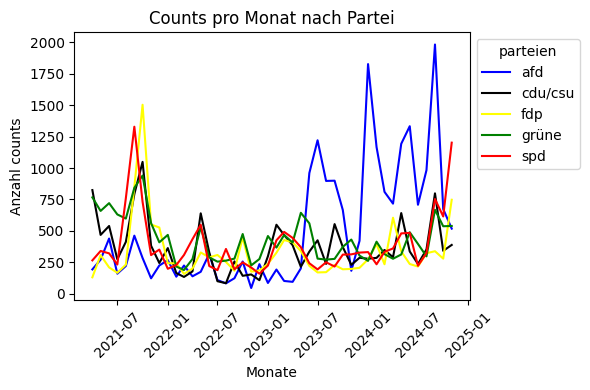

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(data=monthly_data, x="year_month", y="count", hue="partei", palette={"spd": "red", "cdu/csu": "black", "grüne":"green", "fdp":"yellow", "afd":"blue"})
ax.set_title ("Counts pro Monat nach Partei")
ax.set_xlabel("Monate")
ax.set_ylabel("Anzahl counts")

# X-Achse drehen, um Monatsnamen leserlich anzuzeigen
plt.xticks(rotation=45)

#Legende platzieren: anchor für außen, geht auch zb loc='upper left'
plt.legend(title="parteien", bbox_to_anchor=(1, 1))

plt.tight_layout()

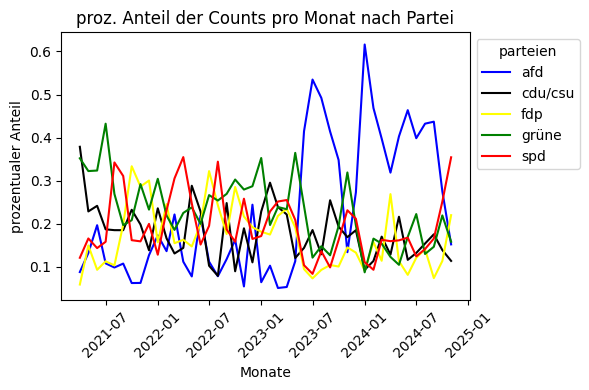

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(data=monthly_data, x="year_month", y="anteil", hue="partei", palette={"spd": "red", "cdu/csu": "black", "grüne":"green", "fdp":"yellow", "afd":"blue"})
ax.set_title ("proz. Anteil der Counts pro Monat nach Partei")
ax.set_xlabel("Monate")
ax.set_ylabel("prozentualer Anteil")

# X-Achse drehen, um Monatsnamen leserlich anzuzeigen
plt.xticks(rotation=45)

#Legende platzieren: anchor für außen, geht auch zb loc='upper left'
plt.legend(title="parteien", bbox_to_anchor=(1, 1))

plt.tight_layout()

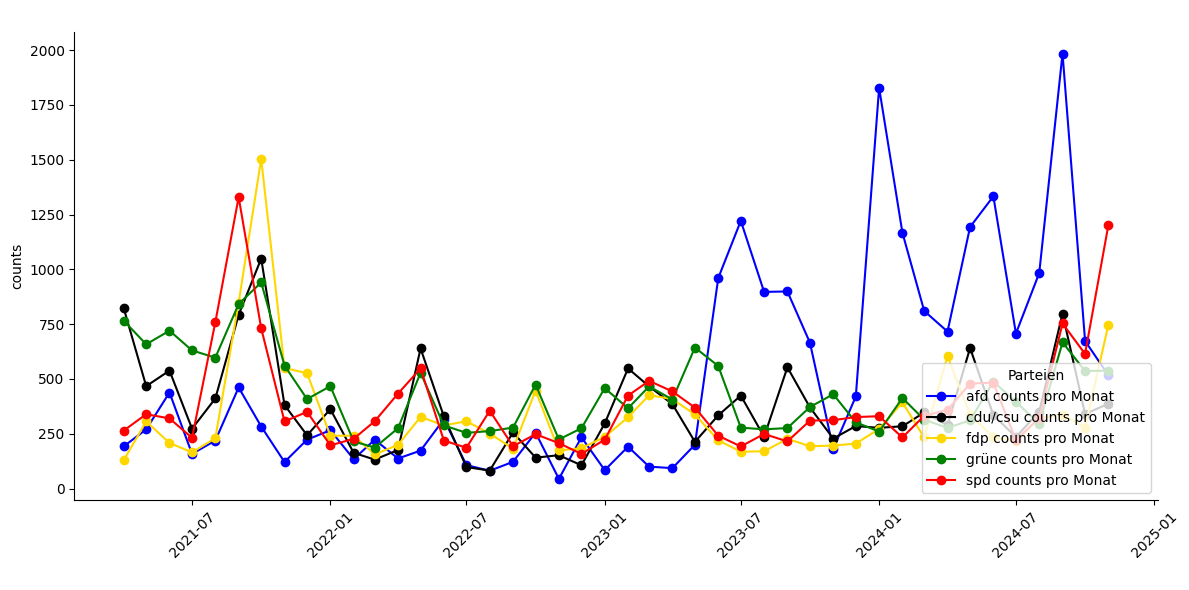

In [22]:
# Farben für die Parteien festlegen
farben = {
    "spd": "red",
    "cdu/csu": "black",
    "grüne": "green",
    "fdp": "gold",  # Für gelb kannst du "gold" oder "yellow" verwenden
    "afd": "blue",
}

# Grafik für jede Partei
parteien = monthly_data["partei"].unique()

plt.figure(figsize=(12, 6))
ax = plt.gca()

for partei in parteien:
    partei_data = monthly_data[monthly_data["partei"] == partei]
    plt.plot(
        partei_data["year_month"], 
        partei_data["count"], 
        marker='o', 
        label=f'{partei} counts pro Monat', 
        color=farben.get(partei, "gray"))

# Entfernen der oberen und rechten Rahmenlinie
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel(" ")
plt.ylabel("counts")
plt.title(" ")
plt.legend (title="Parteien", loc="lower right", bbox_to_anchor=(1, 0))
plt.xticks(rotation=45)
plt.tight_layout()

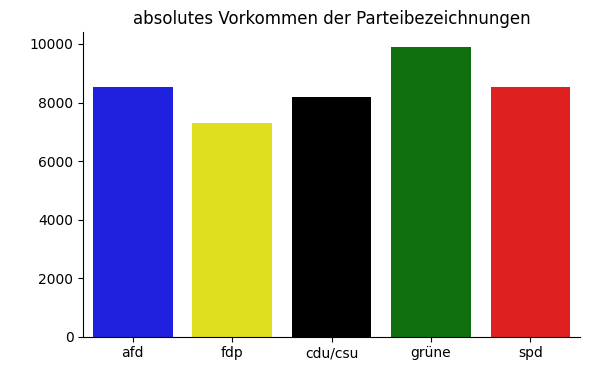

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

#countplot > Anzahl der Beobachtungen pro Kategorie
sns.countplot(data=df, x="partei", hue="partei", palette={'spd': 'red', 'cdu/csu': 'black', 'grüne':'green', 'fdp':'yellow', 'afd':'blue'})
ax.set_title ("absolutes Vorkommen der Parteibezeichnungen")
ax.set_xlabel(" ")
ax.set_ylabel(" ")

# Entfernen der oberen und rechten Rahmenlinie
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#speichern
plt.savefig(os.path.join(PROJECT_DIR, "output", "abs.Vorkommen Parteibezeichnungen.png"))
plt.savefig(os.path.join(PROJECT_DIR, "output", "abs.Vorkommen Parteibezeichnungen.svg"))

plt.tight_layout()

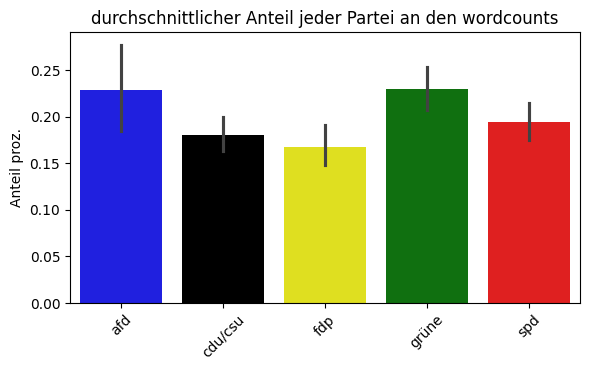

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(data=monthly_data, x="partei", y="anteil", hue="partei", palette={'spd': 'red', 'cdu/csu': 'black', 'grüne':'green', 'fdp':'yellow', 'afd':'blue'})
ax.set_title ("durchschnittlicher Anteil jeder Partei an den wordcounts")
ax.set_xlabel(" ")
ax.set_ylabel("Anteil proz.")

plt.xticks(rotation=45) 

plt.tight_layout()

## polls

### load

In [25]:
EXCEL_FILE_PATH = os.path.join(PROJECT_DIR, 'input/sonntagsfrage.xlsx')


In [26]:
#Arbeitsblätter
sheet_names = [
    'Allensbach', 
    'Verian', 
    'Forsa',
    'Forschungsgruppe Wahlen',
    'infratest dimap',
    'INSA',
    'yougov'
]

In [27]:
# Dictionary zum Speichern der DataFrames
dfs = {}

# Laden jedes Arbeitsblatts, jeweils DataFrame erstellen und ins Dict speichern
for sheet in sheet_names:
    df_name = f'df_{sheet}' 
    
    # Einlesen
    df = pd.read_excel(EXCEL_FILE_PATH, sheet_name=sheet)

    df.columns = df.columns.str.lower()

    # Neue Spalte "institut"
    df['institut'] = sheet.lower()
    
    dfs[df_name] = df
    print(f"DataFrame '{df_name}' wurde erstellt mit Shape: {df.shape}")

# Zugriff auf einen spezifischen DataFrame >> df_forsa = dfs['df_Forsa']

DataFrame 'df_Allensbach' wurde erstellt mit Shape: (89, 13)
DataFrame 'df_Verian' wurde erstellt mit Shape: (530, 13)
DataFrame 'df_Forsa' wurde erstellt mit Shape: (587, 14)
DataFrame 'df_Forschungsgruppe Wahlen' wurde erstellt mit Shape: (137, 13)
DataFrame 'df_infratest dimap' wurde erstellt mit Shape: (261, 13)
DataFrame 'df_INSA' wurde erstellt mit Shape: (334, 13)
DataFrame 'df_yougov' wurde erstellt mit Shape: (103, 13)


### inspect and cleanse

In [28]:
# Die DataFrames über das Dict weiter bearbeiten
# Es sollen nur noch die Spalten Datum, CDU/CSU, SPD, Grüne, FDP, AfD, BSW, Befragte vorhanden sein

# Liste der Spalten
columns_to_keep = ["datum", "cdu/csu", "spd", "grüne", "fdp", "afd", "befragte", "institut"]

for df_name, df in dfs.items():
    df_new = df[columns_to_keep]
    
    dfs[df_name] = df_new
    
    print(f"DataFrame '{df_name}' wurde gefiltert. Neues Shape: {df_new.shape}")


DataFrame 'df_Allensbach' wurde gefiltert. Neues Shape: (89, 8)
DataFrame 'df_Verian' wurde gefiltert. Neues Shape: (530, 8)
DataFrame 'df_Forsa' wurde gefiltert. Neues Shape: (587, 8)
DataFrame 'df_Forschungsgruppe Wahlen' wurde gefiltert. Neues Shape: (137, 8)
DataFrame 'df_infratest dimap' wurde gefiltert. Neues Shape: (261, 8)
DataFrame 'df_INSA' wurde gefiltert. Neues Shape: (334, 8)
DataFrame 'df_yougov' wurde gefiltert. Neues Shape: (103, 8)


In [29]:
# Alle DataFrames im Dictionary zu einem großen DataFrame zusammenführen
df_gesamt = pd.concat(dfs.values(), ignore_index=True)

df_gesamt.sample(2)


,datum,cdu/csu,spd,grüne,fdp,afd,befragte,institut
1003,2017-08-30,0.38,0.24,0.07,0.08,0.09,2501.0,forsa
1173,2014-05-27,0.40,0.25,0.10,0.04,0.06,2503.0,forsa


In [30]:
print(f"Der kombinierte DataFrame hat {df_gesamt.shape[0]} Zeilen und {df_gesamt.shape[1]} Spalten.")

Der kombinierte DataFrame hat 2041 Zeilen und 8 Spalten.


In [31]:
df_gesamt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041 entries, 0 to 2040
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datum     2040 non-null   datetime64[ns]
 1   cdu/csu   2040 non-null   float64       
 2   spd       2040 non-null   float64       
 3   grüne     2040 non-null   float64       
 4   fdp       2039 non-null   float64       
 5   afd       2040 non-null   float64       
 6   befragte  2040 non-null   float64       
 7   institut  2041 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 127.7+ KB


In [32]:
df_gesamt.max()

datum       2024-12-17 00:00:00
cdu/csu                    0.45
spd                        0.33
grüne                      0.28
fdp                        0.16
afd                        0.24
befragte                 3631.0
institut                 yougov
dtype: object

In [33]:
# Start und Enddatum für einen Filter
start_date = pd.to_datetime("2021-04-01")
end_date = pd.to_datetime("2024-11-30")

df_gesamt = df_gesamt[(df_gesamt["datum"] >= start_date) & (df_gesamt["datum"] <= end_date)]


In [34]:
df_gesamt.sample(10)

,datum,cdu/csu,spd,grüne,fdp,afd,befragte,institut
1710,2023-12-12,0.300,0.160,0.125,0.060,0.225,2008.0,insa
90,2024-11-01,0.320,0.160,0.110,0.030,0.170,1443.0,verian
1276,2021-05-21,0.240,0.140,0.250,0.110,0.110,1229.0,forschungsgruppe wahlen
41,2021-08-19,0.275,0.195,0.175,0.110,0.110,1018.0,allensbach
35,2021-12-22,0.240,0.260,0.150,0.130,0.105,1069.0,allensbach
165,2022-10-01,0.270,0.190,0.210,0.080,0.130,1381.0,verian
1790,2023-03-07,0.295,0.200,0.155,0.075,0.155,2007.0,insa
142,2023-03-25,0.280,0.180,0.180,0.070,0.150,1504.0,verian
1211,2024-09-06,0.330,0.150,0.110,0.040,0.170,1328.0,forschungsgruppe wahlen
748,2022-06-14,0.270,0.200,0.230,0.080,0.090,2511.0,forsa


### transform and enrich

In [35]:
# Aggregation: Mittelwerte für die politischen Parteien, Summe für die Befragten
df_aggregiert = df_gesamt.groupby(df_gesamt['datum'].dt.to_period('M')).agg({
    'cdu/csu': 'mean',
    'spd': 'mean',
    'grüne': 'mean',
    'fdp': 'mean',
    'afd': 'mean'
}).reset_index()

# Umwandlung von Perioden zurück zu Datetime (Monat)
df_aggregiert['datum'] = df_aggregiert['datum'].dt.to_timestamp()

# Ergebnis
df_aggregiert.head()

,datum,cdu/csu,spd,grüne,fdp,afd
0,2021-04-01,0.266000,0.148333,0.235333,0.099333,0.107000
1,2021-05-01,0.244063,0.147500,0.253750,0.113125,0.106250
2,2021-06-01,0.276071,0.151429,0.211786,0.121429,0.100714
3,2021-07-01,0.287353,0.156176,0.192647,0.114706,0.104706
4,2021-08-01,0.237187,0.206563,0.187812,0.119063,0.106563


### analyse polls

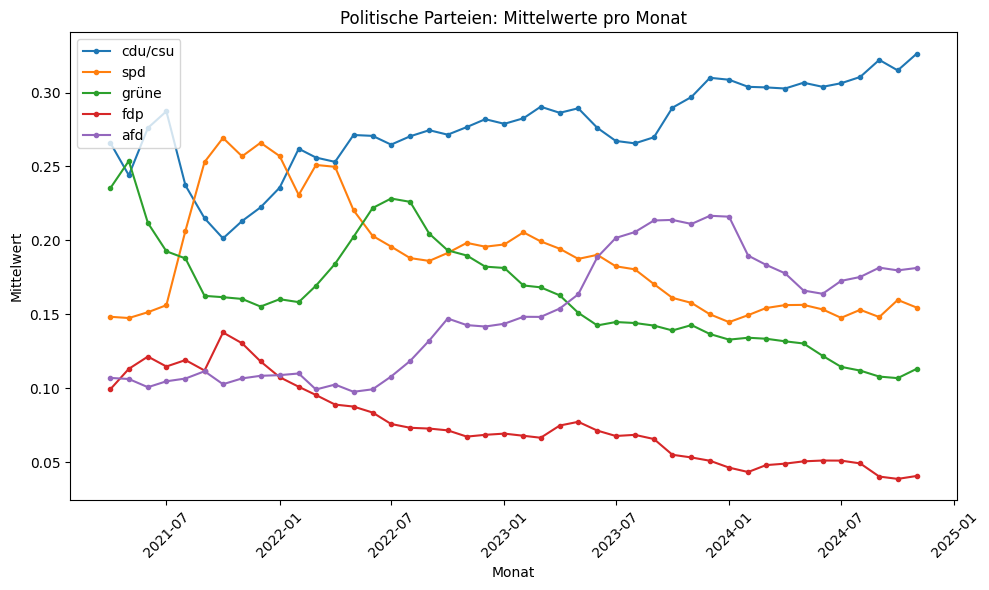

In [36]:
plt.figure(figsize=(10, 6))

# Liniendiagramm für jede Partei
for column in ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']:
    plt.plot(df_aggregiert['datum'], df_aggregiert[column], marker='.', label=column)

plt.xlabel('Monat')
plt.ylabel('Mittelwert')
plt.title('Politische Parteien: Mittelwerte pro Monat')

plt.legend()

# X-Achse drehen, um Monatsnamen leserlich anzuzeigen
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

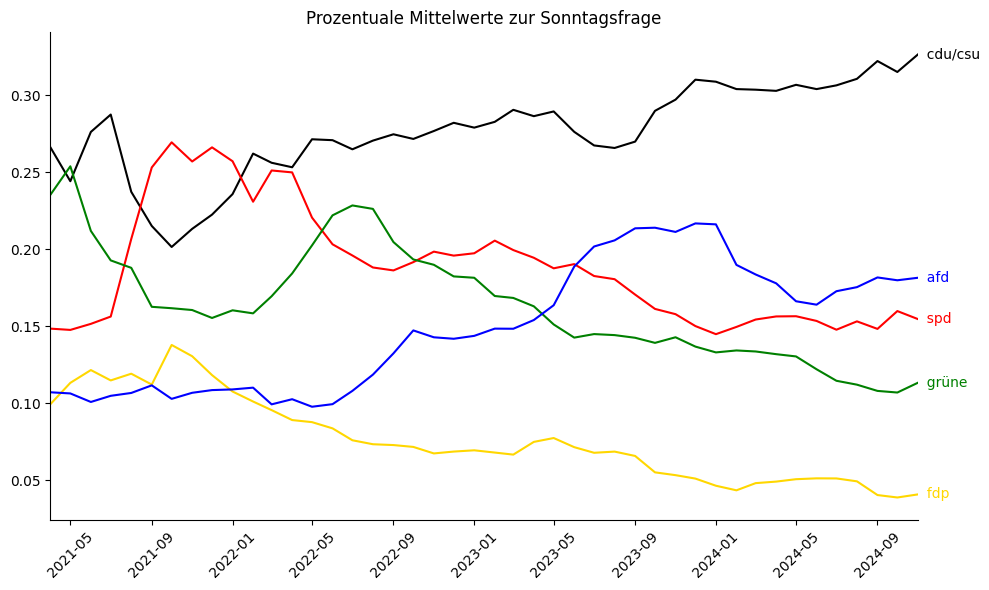

In [37]:
from datetime import datetime

plt.figure(figsize=(10, 6))

# Farbdictionary für die Parteien
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Liniendiagramm für jede Partei
for column in ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']:
    # Plotten der Linie
    plt.plot(df_aggregiert['datum'], df_aggregiert[column], label=column, color=farben[column])
    
    # Hinzufügen der Beschriftung am Ende der Linie
    plt.text(
        df_aggregiert['datum'].iloc[-1],  # X-Wert: letzter Punkt auf der X-Achse
        df_aggregiert[column].iloc[-1],  # Y-Wert: letzter Wert der Spalte
        f"  {column}",                   # Beschriftung mit Leerzeichen für Abstand
        color=farben[column],           # Textfarbe entsprechend der Linie
        va='center',                     # Vertikale Ausrichtung
    )

plt.xlabel('')
plt.ylabel('')
plt.title('Prozentuale Mittelwerte zur Sonntagsfrage')

# Bereich der x-Achse festlegen, damit direkt mit dem ersten Wert gestartet wird
plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])

# X-Achse drehen, um Monatsnamen leserlich anzuzeigen
plt.xticks(rotation=45)

# Entfernen der oberen und rechten Rahmenlinie
ax = plt.gca()  # Aktuelle Achse abrufen
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## comparisons

### trends

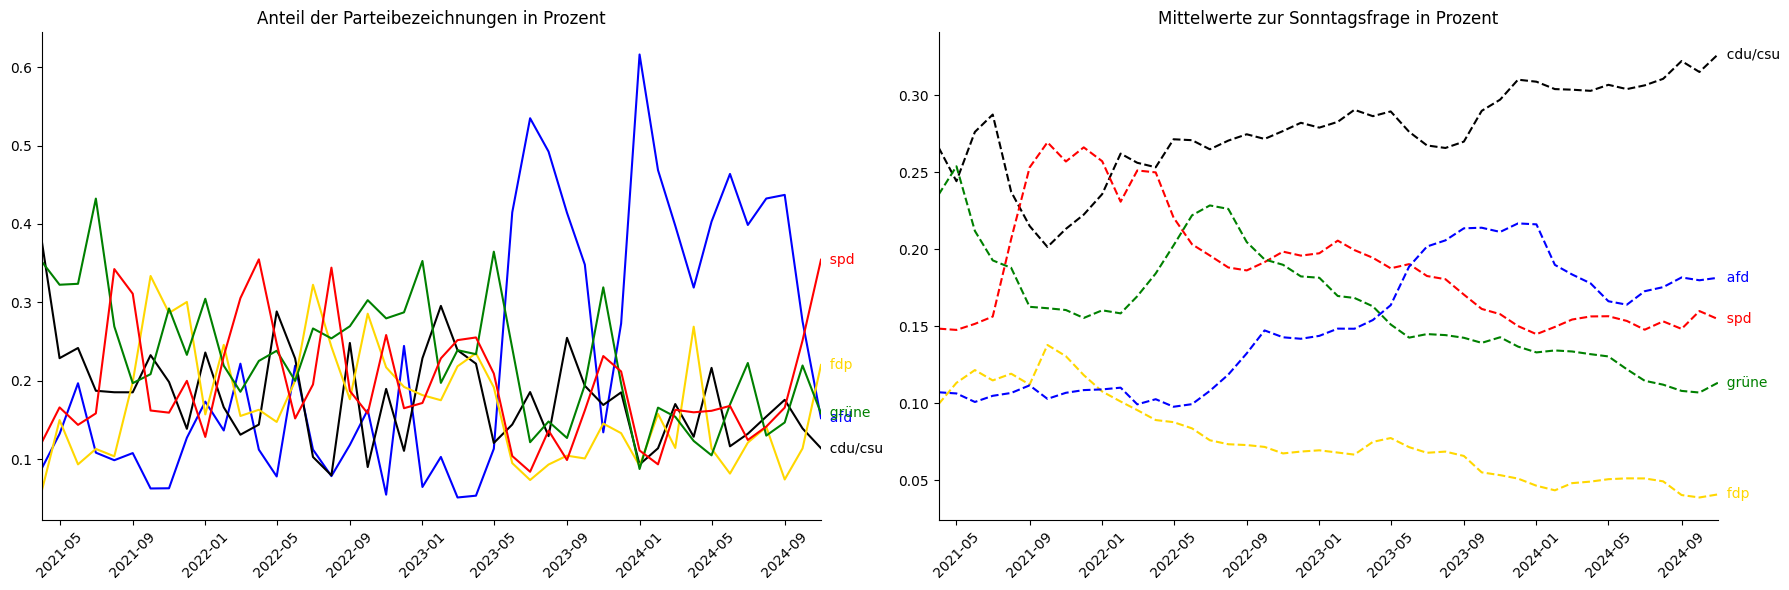

In [38]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Subplots erstellen (2 Spalten, 1 Reihe)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Erste Grafik (prozentualer Anteil) auf ax1
for partei in parteien:
    partei_data = monthly_data[monthly_data["partei"] == partei]    
    # Linie plotten (durchgezogene Linie)
    ax1.plot(
        partei_data["year_month"], 
        partei_data["anteil"], 
        label=f'{partei} anteil pro Monat', 
        color=farben.get(partei, "gray")
    )     
    # Beschriftung am Ende der Linie hinzufügen
    ax1.text(
        partei_data["year_month"].iloc[-1],  # Letzter x-Wert
        partei_data["anteil"].iloc[-1],      # Letzter y-Wert
        f"  {partei}",                       # Beschriftung mit Leerzeichen für Abstand
        color=farben.get(partei, "gray"),    # Textfarbe entsprechend der Linie
        fontsize=10,                         # Schriftgröße
        va='center'                          # Vertikale Ausrichtung
    )

# Zweite Grafik (prozentuale Mittelwerte) auf ax2
for column in ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']:
    # Linie plotten (gestrichelte und blasse Linie)
    ax2.plot(
        df_aggregiert['datum'], 
        df_aggregiert[column], 
        label=f'{column} Mittelwert', 
        color=farben[column], 
        linestyle='--',
        #alpha=0.5       # Blassere Farbe
    )
    
    # Beschriftung am Ende der Linie hinzufügen
    ax2.text(
        df_aggregiert['datum'].iloc[-1],  # X-Wert: letzter Punkt auf der X-Achse
        df_aggregiert[column].iloc[-1],  # Y-Wert: letzter Wert der Spalte
        f"  {column}",                   # Beschriftung mit Leerzeichen für Abstand
        color=farben[column],           # Textfarbe entsprechend der Linie
        va='center',                     # Vertikale Ausrichtung
    ) 

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Anteil der Parteibezeichnungen in Prozent')

ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Mittelwerte zur Sonntagsfrage in Prozent')

# Bereich der x-Achse festlegen, damit direkt mit dem ersten Wert gestartet wird
ax1.set_xlim(partei_data['year_month'].iloc[0], partei_data['year_month'].iloc[-1])
ax2.set_xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])

# X-Achse drehen, um Monatsnamen leserlich anzuzeigen
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Entfernen der oberen und rechten Rahmenlinien
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.savefig(os.path.join(PROJECT_DIR, "output", "Sichtbarkeit vs Sonntagsfrage.png"))
plt.savefig(os.path.join(PROJECT_DIR, "output", "Sichtbarkeit vs Sonntagsfrage.svg"))

plt.tight_layout()
plt.show()



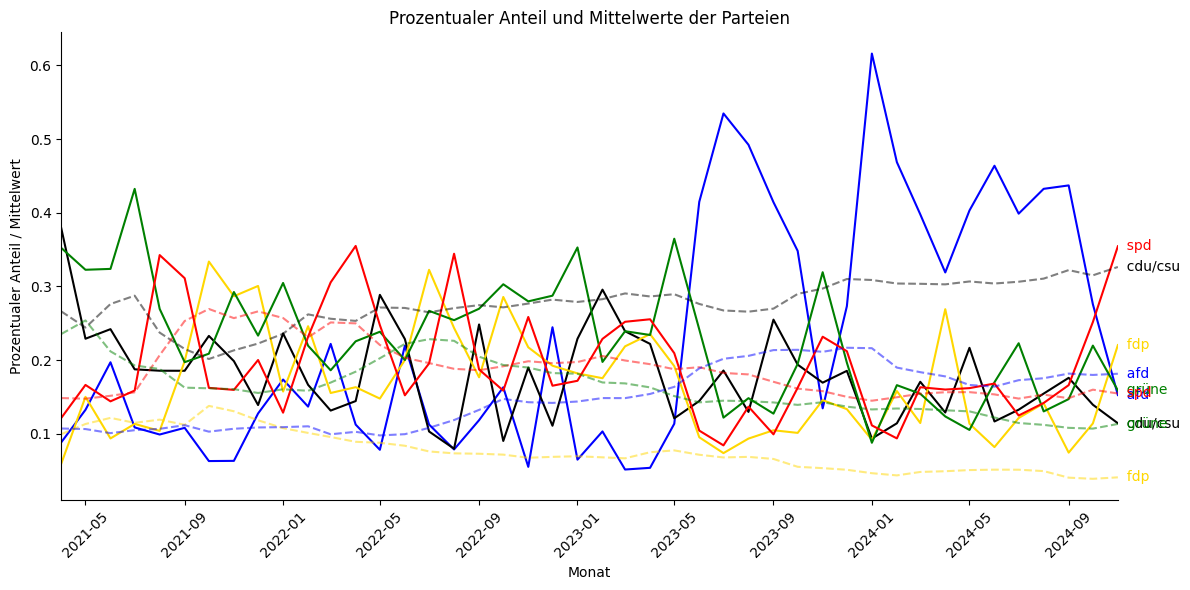

In [39]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

plt.figure(figsize=(12, 6))

# Aktuelle Achse erhalten
ax = plt.gca()

# Plot der ersten Grafik (prozentualer Anteil)
for partei in parteien:
    partei_data = monthly_data[monthly_data["partei"] == partei]    
    # Linie plotten (durchgezogene Linie)
    plt.plot(
        partei_data["year_month"], 
        partei_data["anteil"], 
        label=f'{partei} anteil pro Monat', 
        color=farben.get(partei, "gray")
    )     
    # Beschriftung am Ende der Linie hinzufügen
    plt.text(
        partei_data["year_month"].iloc[-1],  # Letzter x-Wert
        partei_data["anteil"].iloc[-1],      # Letzter y-Wert
        f"  {partei}",                       # Beschriftung mit Leerzeichen für Abstand
        color=farben.get(partei, "gray"),    # Textfarbe entsprechend der Linie
        fontsize=10,                         # Schriftgröße
        va='center'                          # Vertikale Ausrichtung
    )

# Plot der zweiten Grafik (prozentuale Mittelwerte)
for column in ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']:
    # Linie plotten (gestrichelte und blasse Linie)
    plt.plot(
        df_aggregiert['datum'], 
        df_aggregiert[column], 
        label=f'{column} Mittelwert', 
        color=farben[column], 
        linestyle='--',  # Gestrichelte Linie
        alpha=0.5       # Blassere Farbe
    )
    
    # Beschriftung am Ende der Linie hinzufügen
    plt.text(
        df_aggregiert['datum'].iloc[-1],  # X-Wert: letzter Punkt auf der X-Achse
        df_aggregiert[column].iloc[-1],  # Y-Wert: letzter Wert der Spalte
        f"  {column}",                   # Beschriftung mit Leerzeichen für Abstand
        color=farben[column],           # Textfarbe entsprechend der Linie
        va='center',                     # Vertikale Ausrichtung
    ) 

plt.xlabel('Monat')
plt.ylabel('Prozentualer Anteil / Mittelwert')
plt.title('Prozentualer Anteil und Mittelwerte der Parteien')

# Bereich der x-Achse festlegen, damit direkt mit dem ersten Wert gestartet wird
plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])

# X-Achse drehen, um Monatsnamen leserlich anzuzeigen
plt.xticks(rotation=45)

# Entfernen der oberen und rechten Rahmenlinie
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


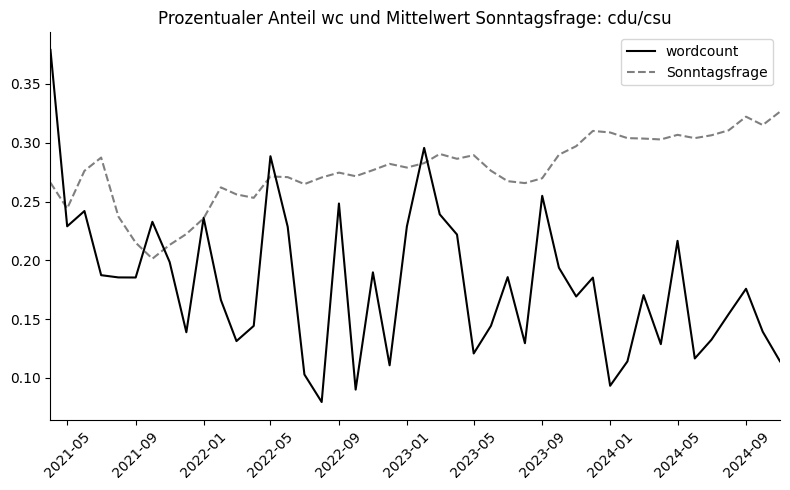

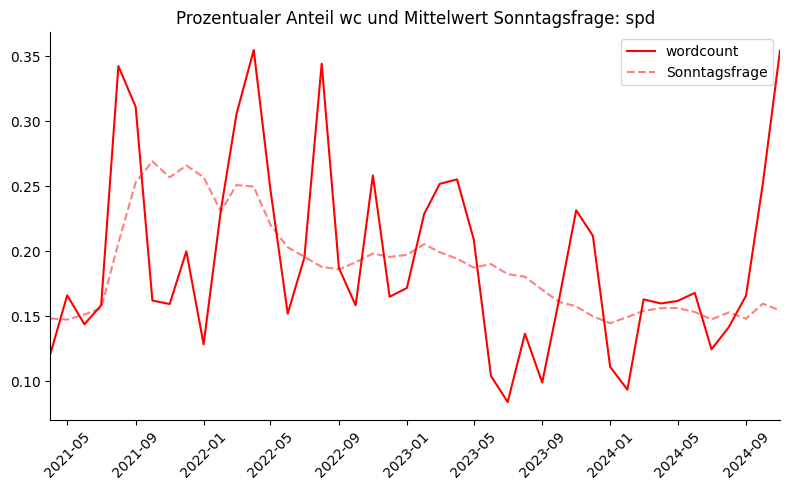

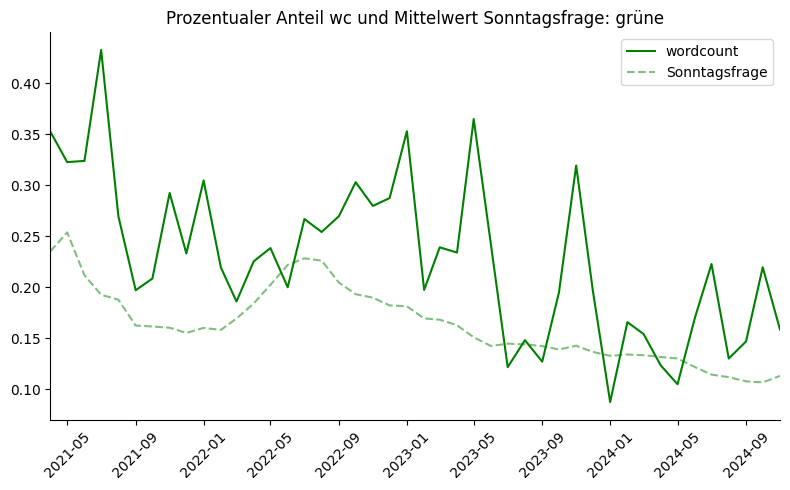

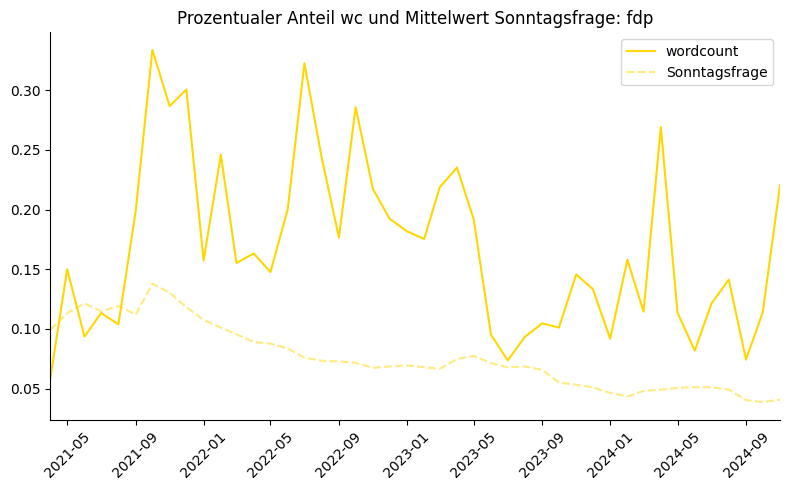

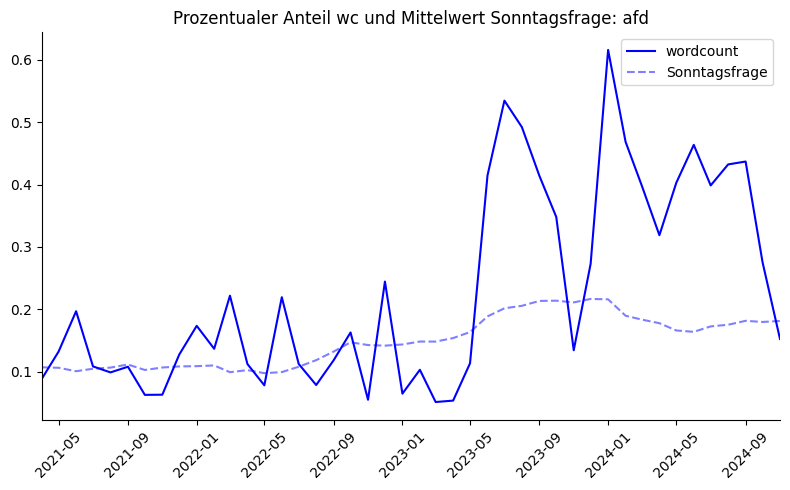

In [40]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Liste der Parteien
parteien = ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']

# Für jede Partei ein separates Diagramm erstellen
for partei in parteien:
    plt.figure(figsize=(8, 5))
    
    # Daten für die Partei filtern
    partei_monthly_data = monthly_data[monthly_data["partei"] == partei]
    
    # Durchgezogene Linie (monthly_data)
    plt.plot(
        partei_monthly_data["year_month"], 
        partei_monthly_data["anteil"], 
        label= 'wordcount', 
        color=farben.get(partei, "gray")
    )
    
    # Gestrichelte Linie (df_aggregiert)
    plt.plot(
        df_aggregiert['datum'], 
        df_aggregiert[partei], 
        label= 'Sonntagsfrage', 
        color=farben.get(partei, "gray"), 
        linestyle='--', 
        alpha=0.5
    )
    
    # Diagrammtitel und Achsentitel
    plt.title(f'Prozentualer Anteil wc und Mittelwert Sonntagsfrage: {partei}')
    plt.xlabel('')
    plt.ylabel('')
    
    # Bereich der x-Achse festlegen
    plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])
    
    # X-Achse drehen, um Monatsnamen leserlich anzuzeigen
    plt.xticks(rotation=45)
    
    plt.legend()
    
    # Rahmenlinien oben und rechts entfernen
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


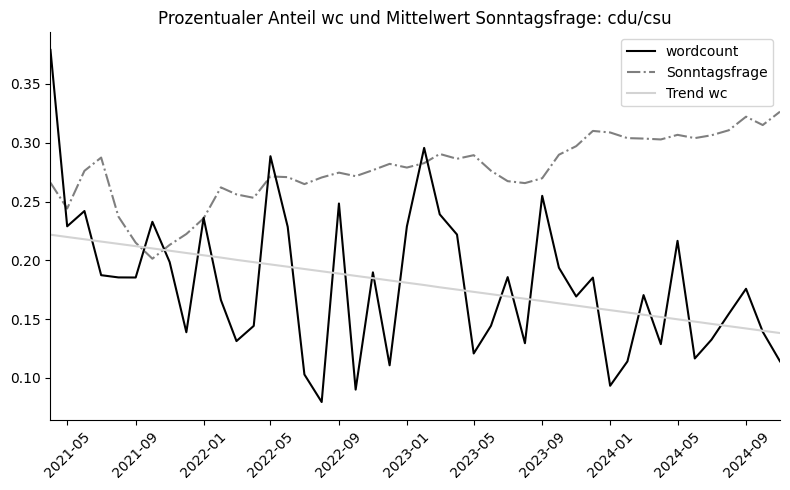

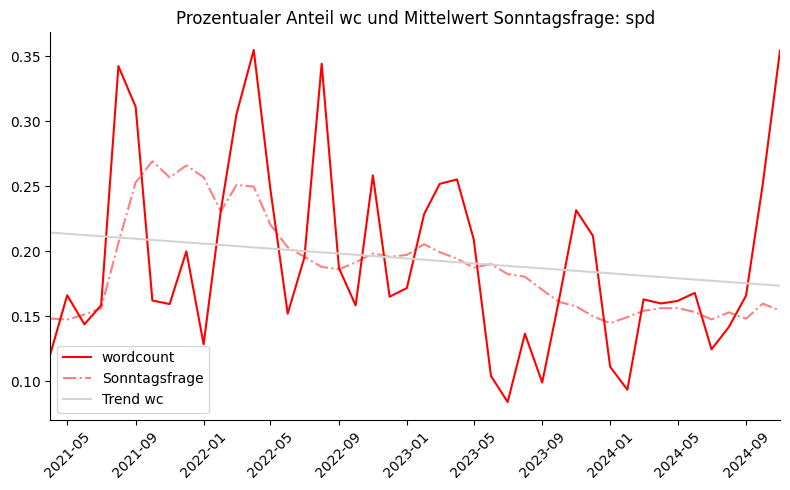

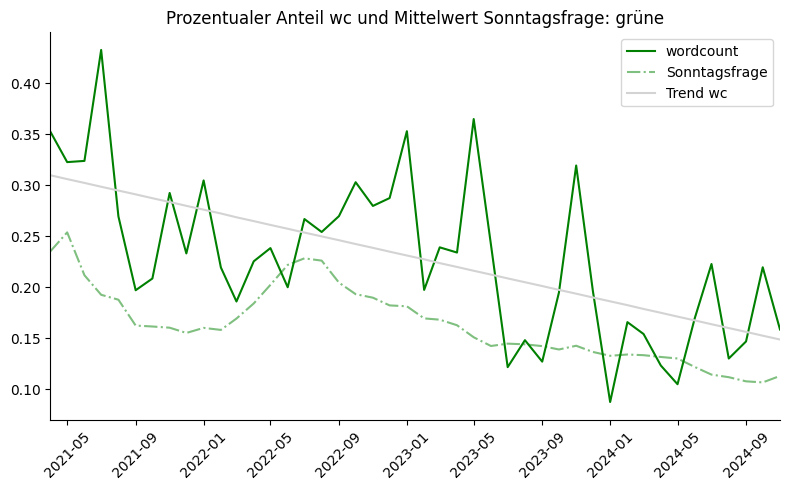

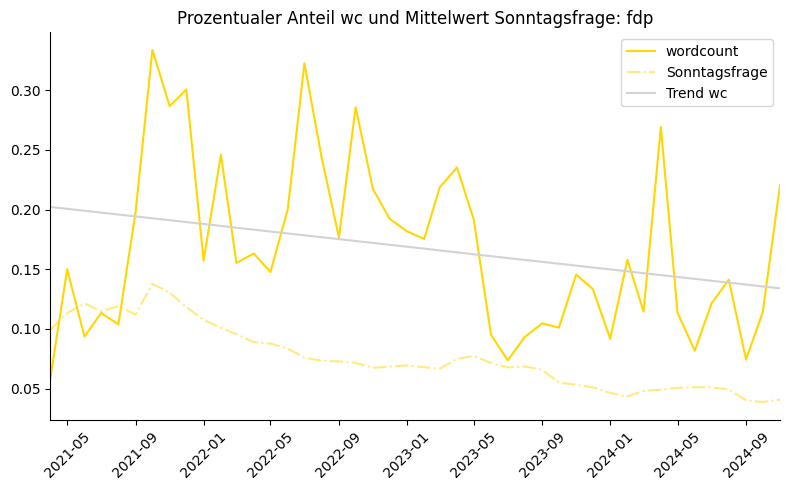

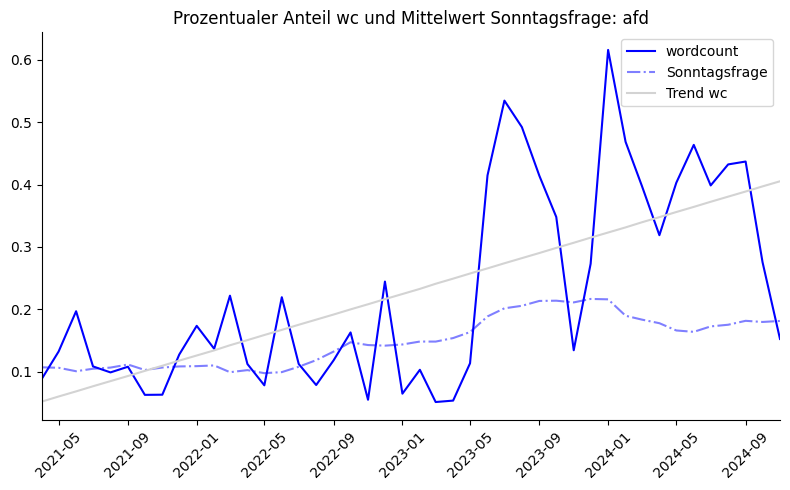

In [41]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Liste der Parteien
parteien = ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']

# Für jede Partei ein separates Diagramm erstellen
for partei in parteien:
    plt.figure(figsize=(8, 5))  # Neue Grafik für jede Partei erstellen
    
    # Daten für die Partei filtern
    partei_monthly_data = monthly_data[monthly_data["partei"] == partei]
    
    # Durchgezogene Linie (monthly_data)
    plt.plot(
        partei_monthly_data["year_month"], 
        partei_monthly_data["anteil"], 
        label='wordcount', 
        color=farben.get(partei)
    )
    
    # Gestrichelte Linie (df_aggregiert)
    plt.plot(
        df_aggregiert['datum'], 
        df_aggregiert[partei], 
        label='Sonntagsfrage', 
        color=farben.get(partei), 
        linestyle='-.', 
        alpha=0.5
    )
    
    # Trendlinie hinzufügen
    if not partei_monthly_data.empty:
        # Konvertiere year_month in Zahlen für die Regression
        x = np.arange(len(partei_monthly_data["year_month"]))
        y = partei_monthly_data["anteil"].values
        
        # Lineare Regression berechnen
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        
        # Trendlinie plotten
        plt.plot(
            partei_monthly_data["year_month"], 
            p(x), 
            color= 'lightgray', 
            linestyle='-', 
            label='Trend wc'
        )
  
    plt.title(f'Prozentualer Anteil wc und Mittelwert Sonntagsfrage: {partei}')
    plt.xlabel('')
    plt.ylabel('')
    
    # Bereich der x-Achse festlegen
    plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])
    
    # X-Achse drehen, um Monatsnamen leserlich anzuzeigen
    plt.xticks(rotation=45)
    
    plt.legend()
    
    # Rahmenlinien oben und rechts entfernen
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


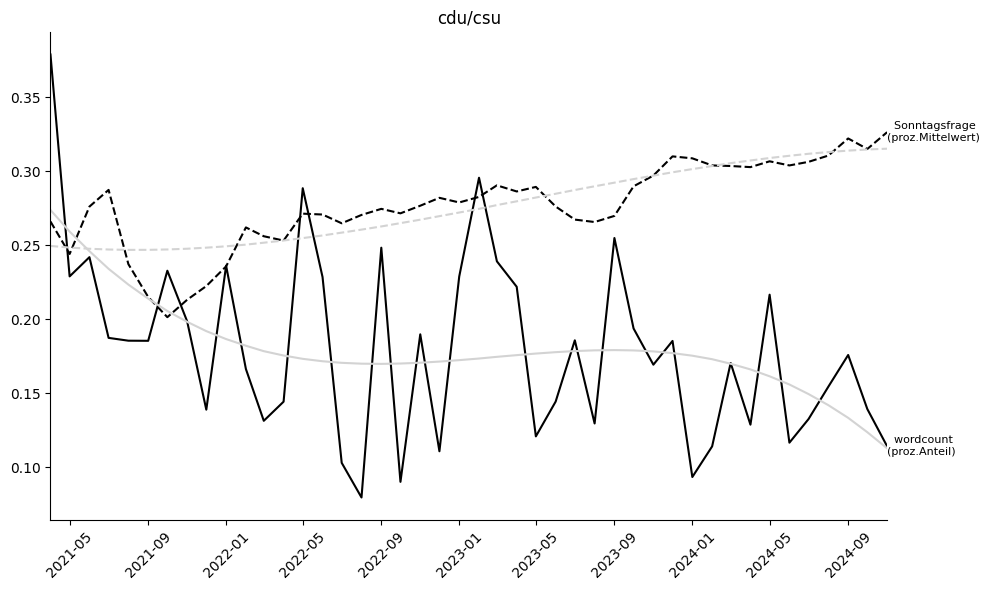

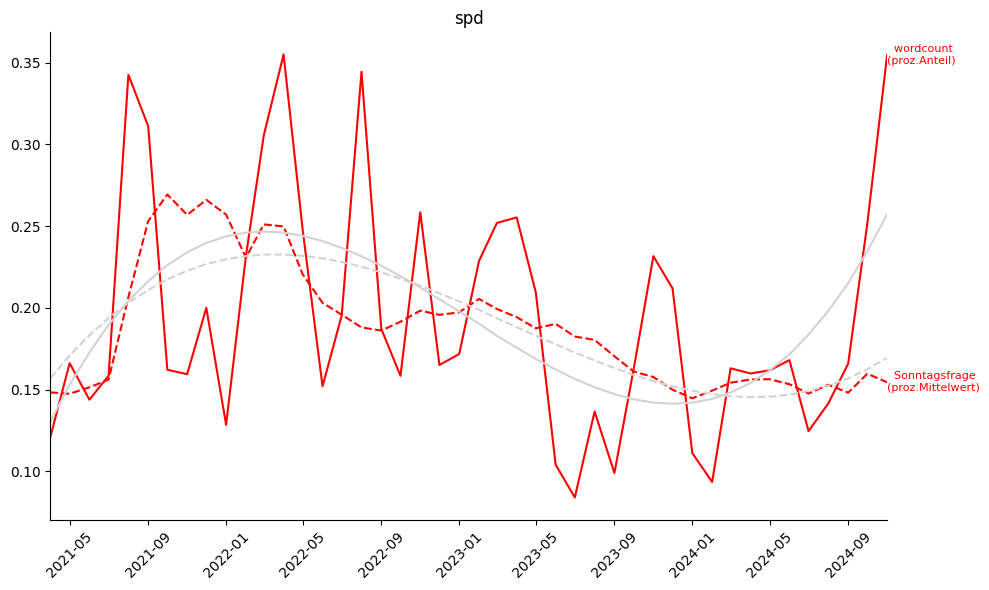

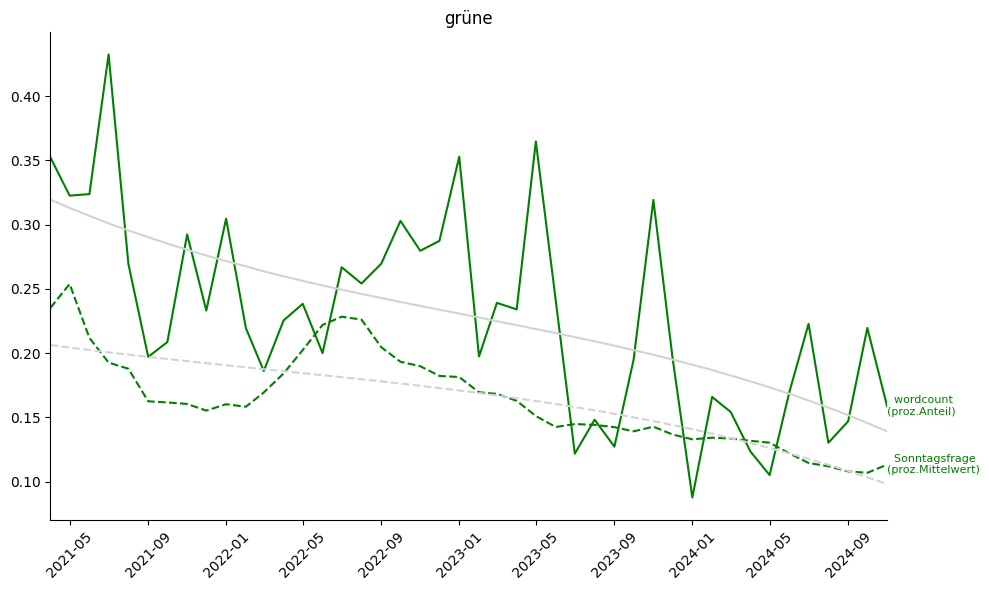

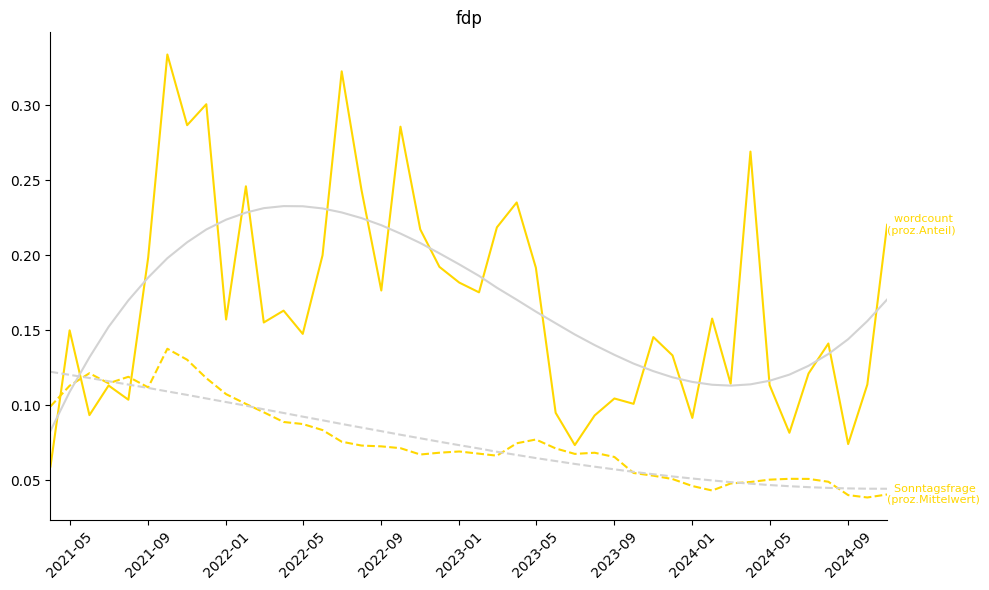

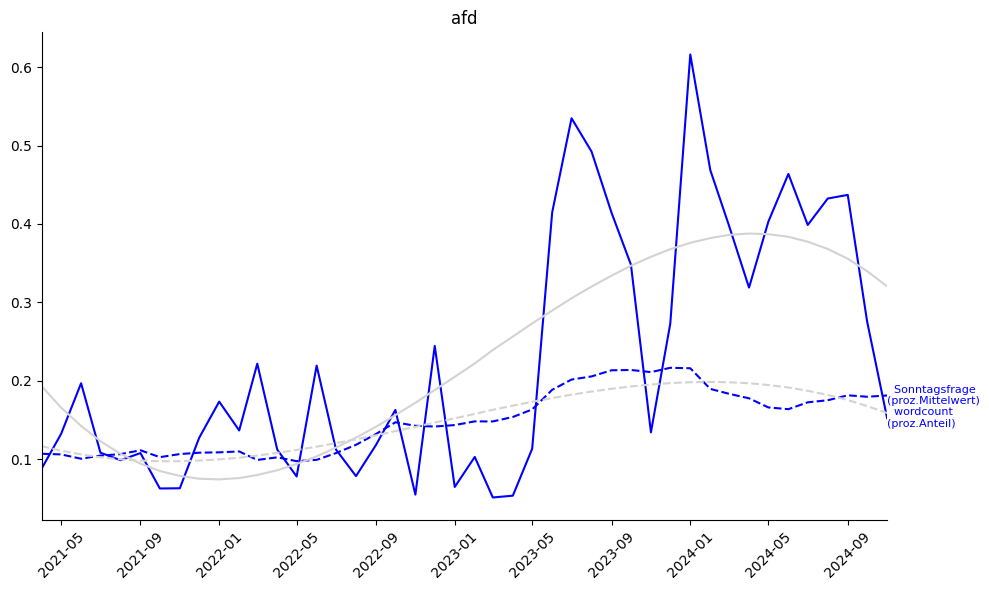

In [42]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Liste der Parteien
parteien = ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']

# Für jede Partei ein separates Diagramm erstellen
for partei in parteien:
    plt.figure(figsize=(10, 6))
    
    # Daten für die Partei filtern
    partei_monthly_data = monthly_data[monthly_data["partei"] == partei]
    
    # Durchgezogene Linie (monthly_data)
    plt.plot(
        partei_monthly_data["year_month"], 
        partei_monthly_data["anteil"], 
        label='wordcount', 
        color=farben.get(partei, "gray")
    )
    # Beschriftung am Ende der Linie hinzufügen (monthly_data)
    plt.text(
        partei_monthly_data["year_month"].iloc[-1],  # Letzter x-Wert
        partei_monthly_data["anteil"].iloc[-1],      # Letzter y-Wert
        f'  wordcount\n(proz.Anteil)',               # Beschriftung mit Leerzeichen für Abstand
        color=farben.get(partei, "gray"),            # Textfarbe entsprechend der Linie
        fontsize=8,                                 # Schriftgröße
        va='center'                                  # Vertikale Ausrichtung
    )
    
    # Gestrichelte Linie (df_aggregiert)
    plt.plot(
        df_aggregiert['datum'], 
        df_aggregiert[partei], 
        label='Sonntagsfrage', 
        color=farben.get(partei, "gray"), 
        linestyle='--', 
        #alpha=0.5
    )
    # Beschriftung am Ende der Linie hinzufügen (df_aggregiert)
    plt.text(
        df_aggregiert['datum'].iloc[-1],  # Letzter x-Wert
        df_aggregiert[partei].iloc[-1],   # Letzter y-Wert
        f'  Sonntagsfrage\n(proz.Mittelwert)', # Beschriftung mit Leerzeichen für Abstand
        color=farben.get(partei, "gray"), # Textfarbe entsprechend der Linie
        fontsize=8,                      # Schriftgröße
        va='center'                       # Vertikale Ausrichtung
    )

    # Trendlinie hinzufügen wordcount
    if not partei_monthly_data.empty:
        # Konvertiere year_month in Zahlen für die Regression
        x = np.arange(len(partei_monthly_data["year_month"]))
        y = partei_monthly_data["anteil"].values
        
        # Lineare Regression berechnen
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        
        # Trendlinie plotten
        plt.plot(
            partei_monthly_data["year_month"], 
            p(x), 
            color= 'lightgray', 
            linestyle='-'
        )

    # Trendlinie hinzufügen Sonntagsfrage
    if not df_aggregiert.empty:
        # Konvertiere datum in Zahlen für die Regression
        x = np.arange(len(df_aggregiert["datum"]))
        y = df_aggregiert[partei].values
        
        # Lineare Regression berechnen
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        
        # Trendlinie plotten
        plt.plot(
            df_aggregiert["datum"], 
            p(x), 
            color= 'lightgray', 
            linestyle='--'
        )
    
    plt.title(f'{partei}')
    plt.xlabel('')
    plt.ylabel('')
    
    # Bereich der x-Achse festlegen
    plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])
    
    # X-Achse drehen, um Monatsnamen leserlich anzuzeigen
    plt.xticks(rotation=45)
    
    # Rahmenlinien oben und rechts entfernen
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Dateinamen ohne ungültige Zeichen
    sichere_partei = partei.replace('/', '_')

    # speichern
    plt.savefig(os.path.join(PROJECT_DIR, "output", f"trends_{sichere_partei}.svg"))
    plt.savefig(os.path.join(PROJECT_DIR, "output", f"trends_{sichere_partei}.png"))
 
    plt.tight_layout()
    plt.show()


### examination of correlation and differences

In [43]:
monthly_data.head()

,year_month,partei,count,anteil
0,2021-04-01,afd,192,0.088276
1,2021-04-01,cdu/csu,824,0.378851
2,2021-04-01,fdp,129,0.059310
3,2021-04-01,grüne,766,0.352184
4,2021-04-01,spd,264,0.121379


In [44]:
df_aggregiert.head()

,datum,cdu/csu,spd,grüne,fdp,afd
0,2021-04-01,0.266000,0.148333,0.235333,0.099333,0.107000
1,2021-05-01,0.244063,0.147500,0.253750,0.113125,0.106250
2,2021-06-01,0.276071,0.151429,0.211786,0.121429,0.100714
3,2021-07-01,0.287353,0.156176,0.192647,0.114706,0.104706
4,2021-08-01,0.237187,0.206563,0.187812,0.119063,0.106563


In [45]:
df_aggregiert.max()

datum      2024-11-01 00:00:00
cdu/csu               0.326364
spd                   0.269318
grüne                  0.25375
fdp                   0.137727
afd                   0.216667
dtype: object

In [46]:
# DataFrame von langem in breites Format umwandeln
monthly_data_wide = monthly_data.pivot(index='year_month', columns='partei', values='anteil')

# Spaltennamen zurücksetzen
monthly_data_wide = monthly_data_wide.reset_index()
monthly_data_wide.columns.name = None

monthly_data_wide.head()

,year_month,afd,cdu/csu,fdp,grüne,spd
0,2021-04-01,0.088276,0.378851,0.059310,0.352184,0.121379
1,2021-05-01,0.132353,0.228922,0.150000,0.322549,0.166176
2,2021-06-01,0.196942,0.241906,0.093525,0.323741,0.143885
3,2021-07-01,0.108442,0.187371,0.113246,0.432395,0.158545
4,2021-08-01,0.098827,0.185469,0.103791,0.269404,0.342509


In [47]:
monthly_data_wide.max()

year_month    2024-11-01 00:00:00
afd                      0.616111
cdu/csu                  0.378851
fdp                      0.333703
grüne                    0.432395
spd                      0.354918
dtype: object

In [48]:
# Merging auf die jeweilige Datumsspalte
merged_df = pd.merge(monthly_data_wide, df_aggregiert, left_on='year_month', right_on='datum', suffixes=('_wide', '_agg'))

# Leere Liste für die Ergebnisse
correlation_results = {}

# Liste der Parteien
parteien = ['spd', 'cdu/csu', 'grüne', 'fdp', 'afd']

# Korrelation für jede Partei
for partei in parteien:
    corr = merged_df[f'{partei}_wide'].corr(merged_df[f'{partei}_agg'])
    correlation_results[partei] = corr

# Ergebnisse
for partei, corr in correlation_results.items():
    print(f'Korrelation für {partei}: {corr:.2f}')


Korrelation für spd: 0.35
Korrelation für cdu/csu: -0.24
Korrelation für grüne: 0.61
Korrelation für fdp: 0.32
Korrelation für afd: 0.71


In [49]:
merged_df.head()

,year_month,afd_wide,cdu/csu_wide,fdp_wide,grüne_wide,spd_wide,datum,cdu/csu_agg,spd_agg,grüne_agg,fdp_agg,afd_agg
0,2021-04-01,0.088276,0.378851,0.059310,0.352184,0.121379,2021-04-01,0.266000,0.148333,0.235333,0.099333,0.107000
1,2021-05-01,0.132353,0.228922,0.150000,0.322549,0.166176,2021-05-01,0.244063,0.147500,0.253750,0.113125,0.106250
2,2021-06-01,0.196942,0.241906,0.093525,0.323741,0.143885,2021-06-01,0.276071,0.151429,0.211786,0.121429,0.100714
3,2021-07-01,0.108442,0.187371,0.113246,0.432395,0.158545,2021-07-01,0.287353,0.156176,0.192647,0.114706,0.104706
4,2021-08-01,0.098827,0.185469,0.103791,0.269404,0.342509,2021-08-01,0.237187,0.206563,0.187812,0.119063,0.106563


In [50]:
from minepy import MINE

# MINE-Objekt
mine = MINE()

# MIC für die Spalten 'spd_agg' und 'spd_wide'
mine.compute_score(merged_df['spd_agg'], merged_df['spd_wide'])
mic_value = mine.mic()

print(f"MIC between 'spd_agg' and 'spd_wide': {mic_value}")


MIC between 'spd_agg' and 'spd_wide': 0.2638592171275071


In [51]:
# MINE-Objekt
mine = MINE()

# MIC für die Spalten 'spd_agg' und 'spd_wide'
mine.compute_score(merged_df['afd_agg'], merged_df['afd_wide'])
mic_value = mine.mic()

print(f"MIC between 'afd_agg' and 'afd_wide': {mic_value}")

MIC between 'afd_agg' and 'afd_wide': 0.7375130663813263


In [52]:
# MINE-Objekt
mine = MINE()

# MIC für die Spalten 'spd_agg' und 'spd_wide'
mine.compute_score(merged_df['cdu/csu_agg'], merged_df['cdu/csu_wide'])
mic_value = mine.mic()

print(f"MIC between 'cdu/csu_agg' and 'cdu/csu_wide': {mic_value}")

MIC between 'cdu/csu_agg' and 'cdu/csu_wide': 0.36382519652079326


In [53]:
# MINE-Objekt
mine = MINE()

# MIC für die Spalten 'spd_agg' und 'spd_wide'
mine.compute_score(merged_df['grüne_agg'], merged_df['grüne_wide'])
mic_value = mine.mic()

print(f"MIC between 'grüne_agg' and 'grüne_wide': {mic_value}")

MIC between 'grüne_agg' and 'grüne_wide': 0.5955348662109379


In [54]:
# MINE-Objekt
mine = MINE()

# MIC für die Spalten 'spd_agg' und 'spd_wide'
mine.compute_score(merged_df['fdp_agg'], merged_df['fdp_wide'])
mic_value = mine.mic()

print(f"MIC between 'fdp_agg' and 'fdp_wide': {mic_value}")

MIC between 'fdp_agg' and 'fdp_wide': 0.2914218870702902


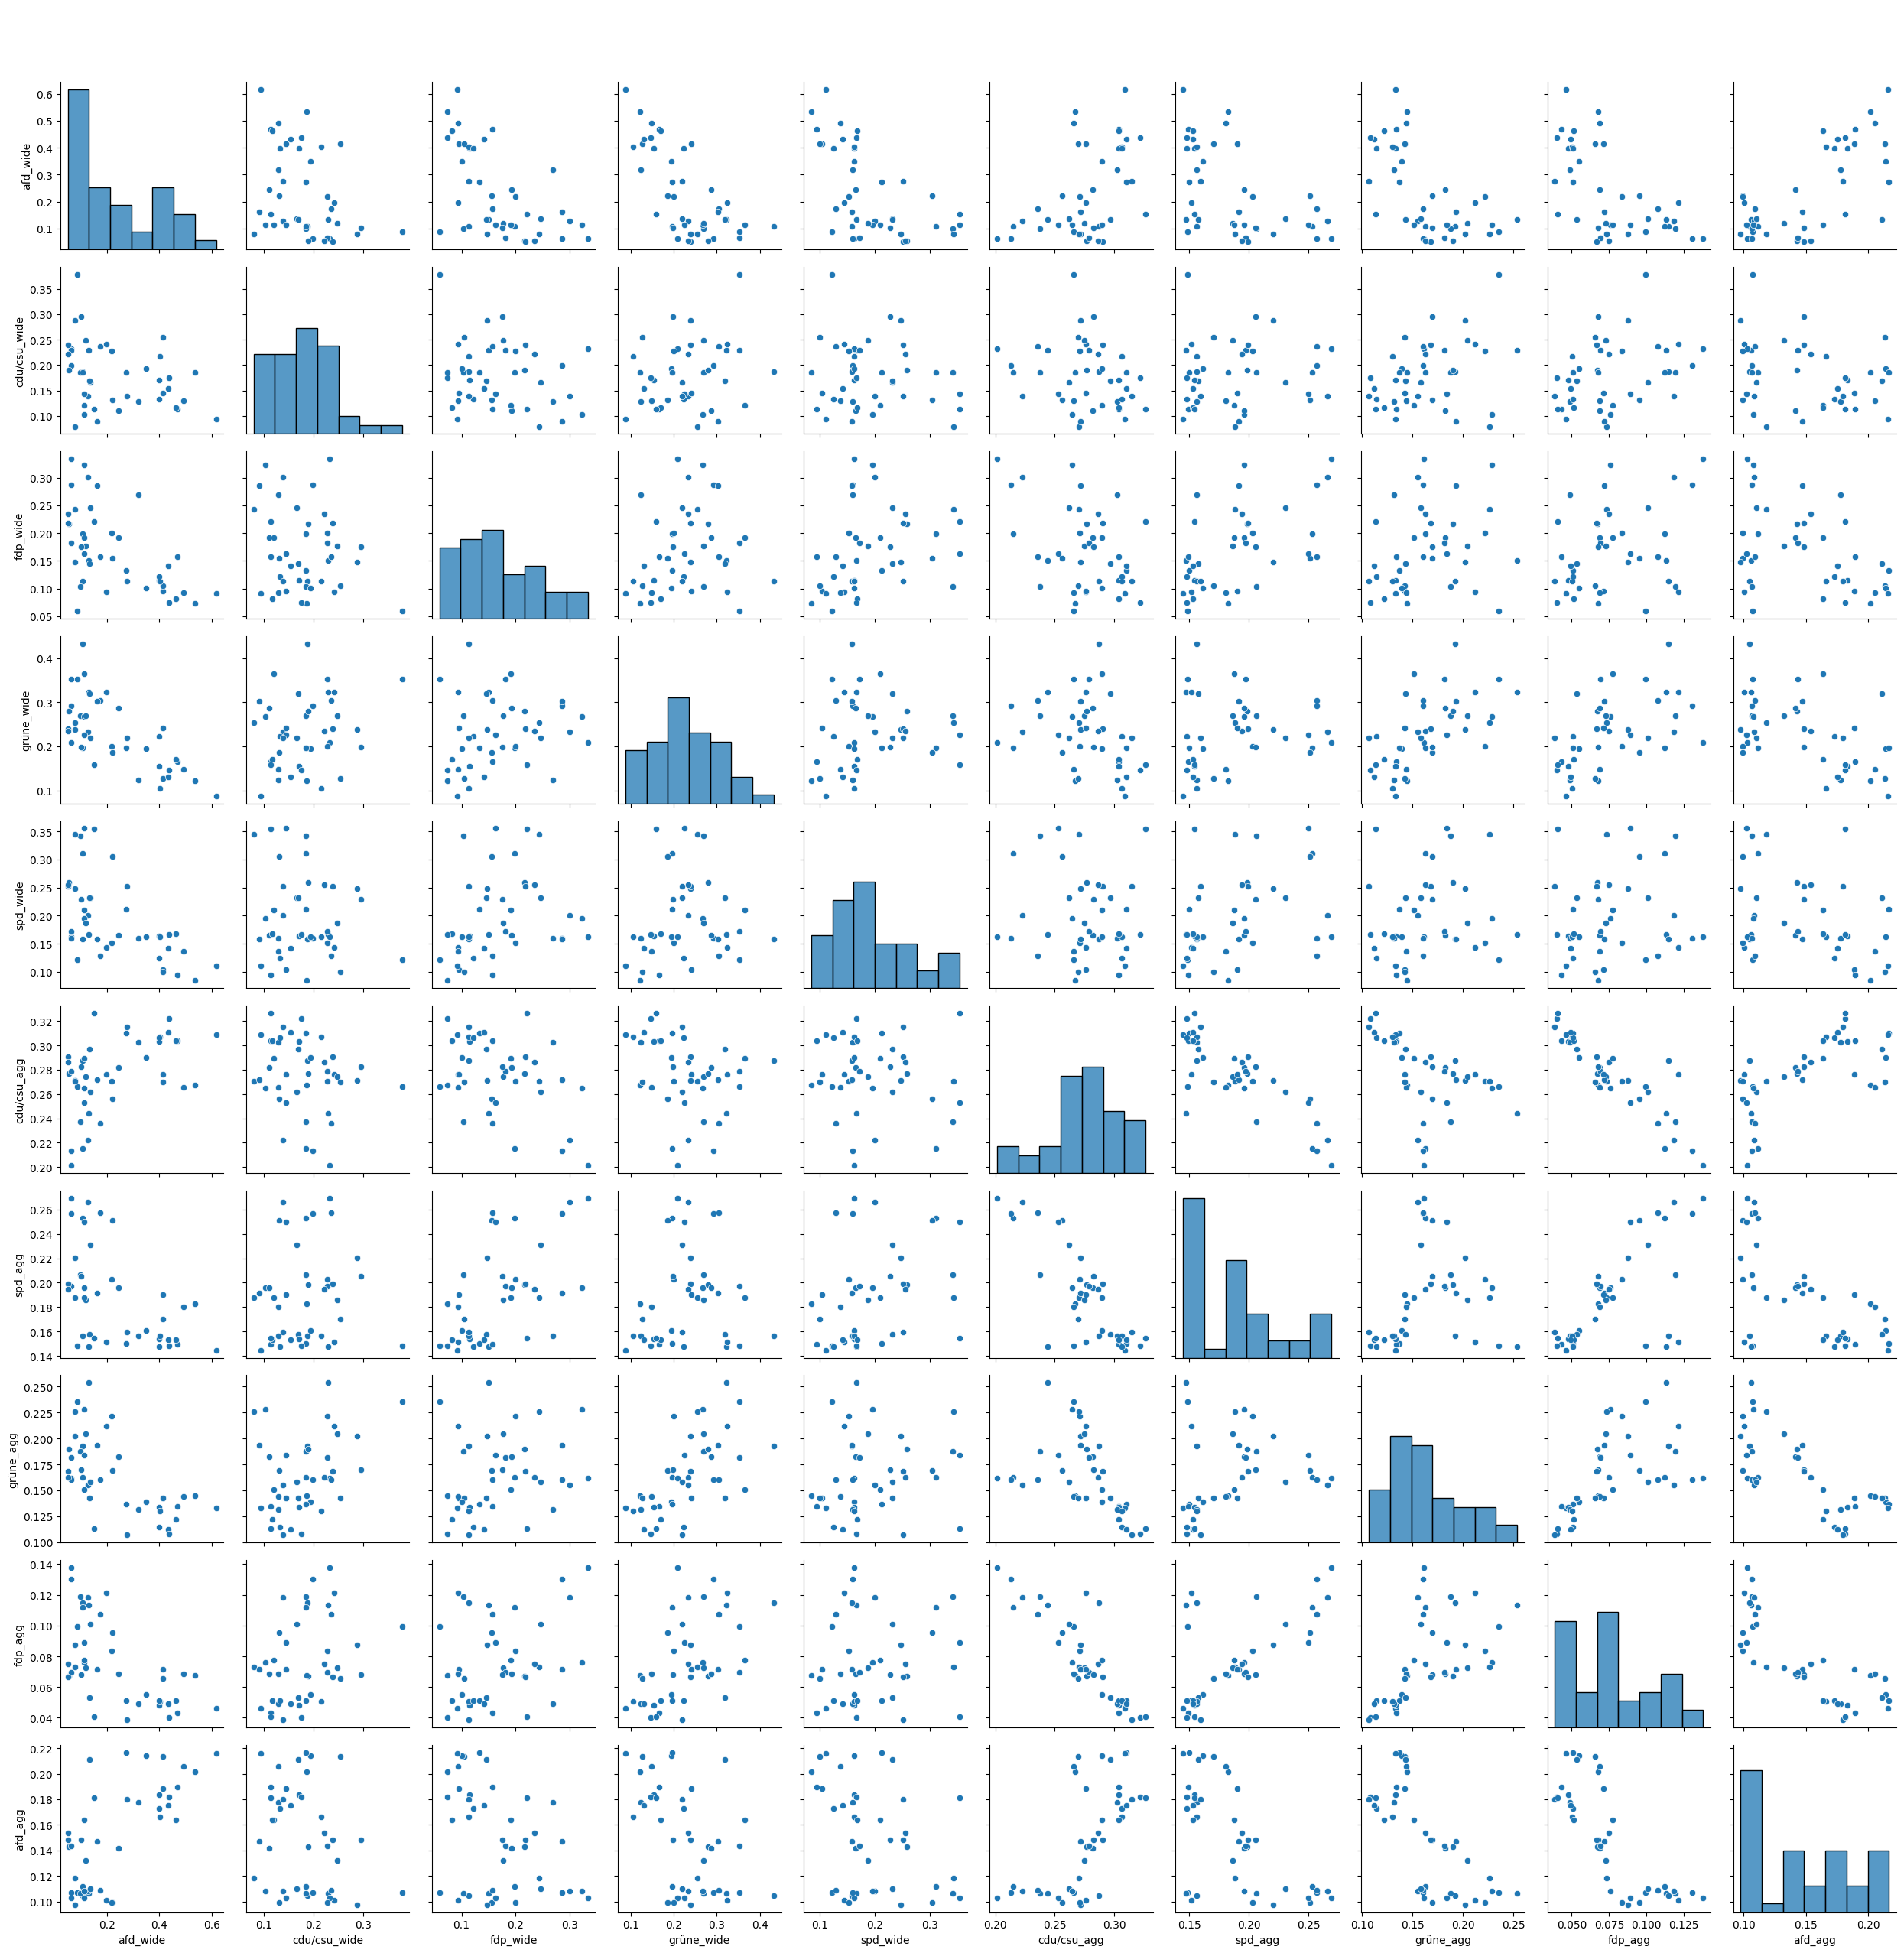

In [55]:
# Pairplot-Matrix
sns.pairplot(merged_df)

plt.suptitle(" ", y=1.02)

plt.tight_layout()
plt.show()

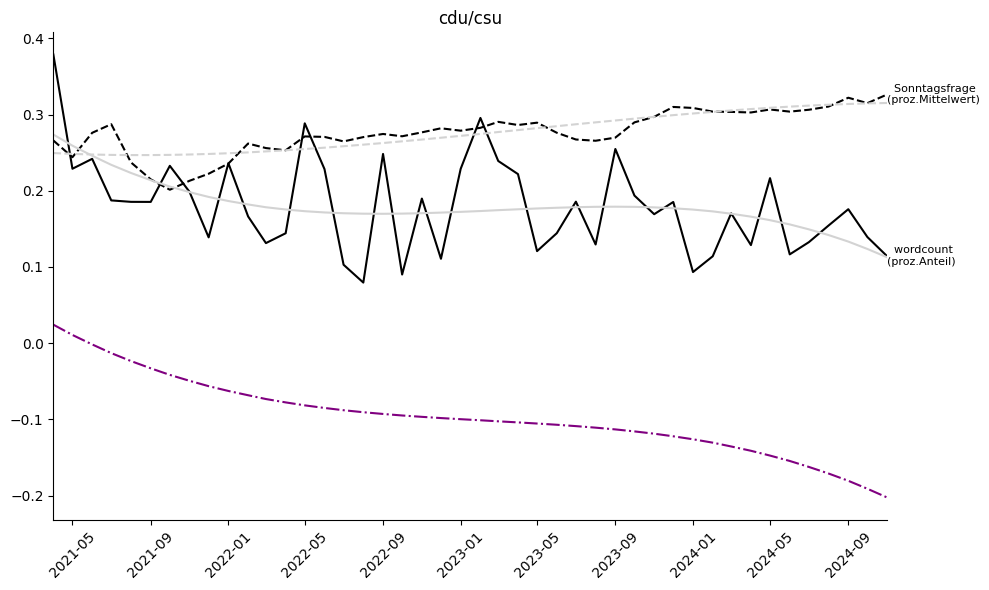

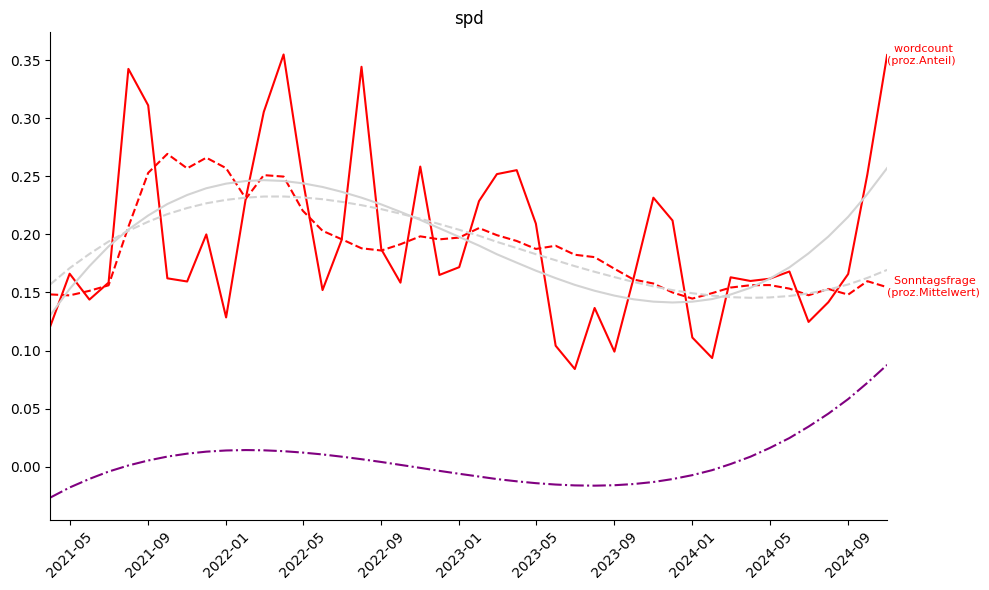

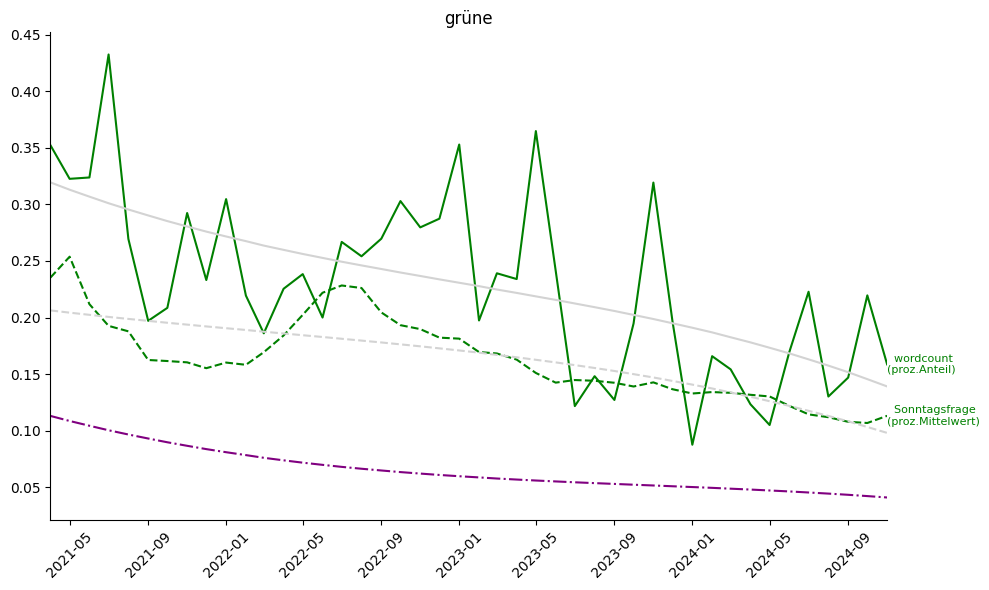

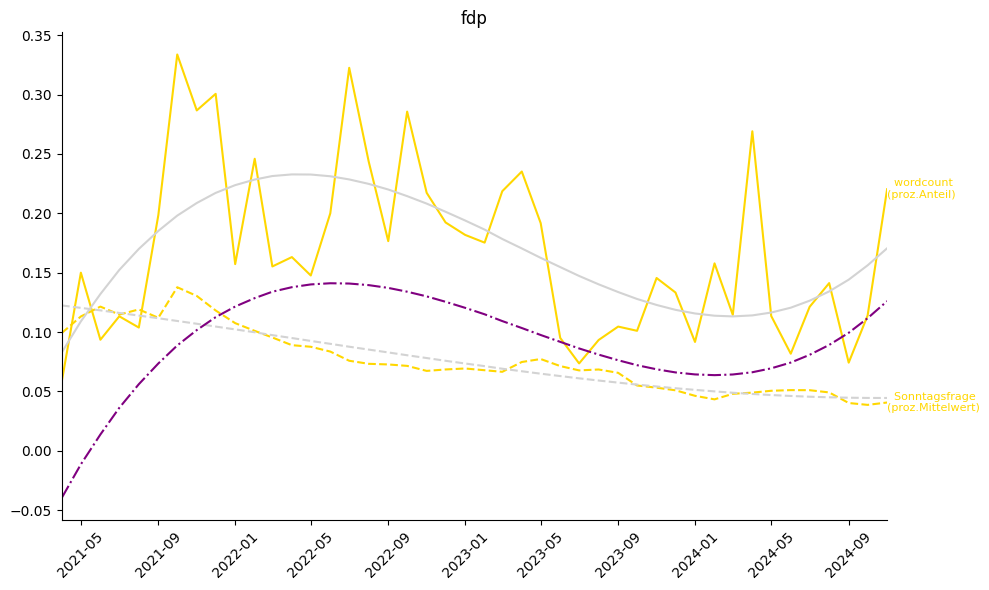

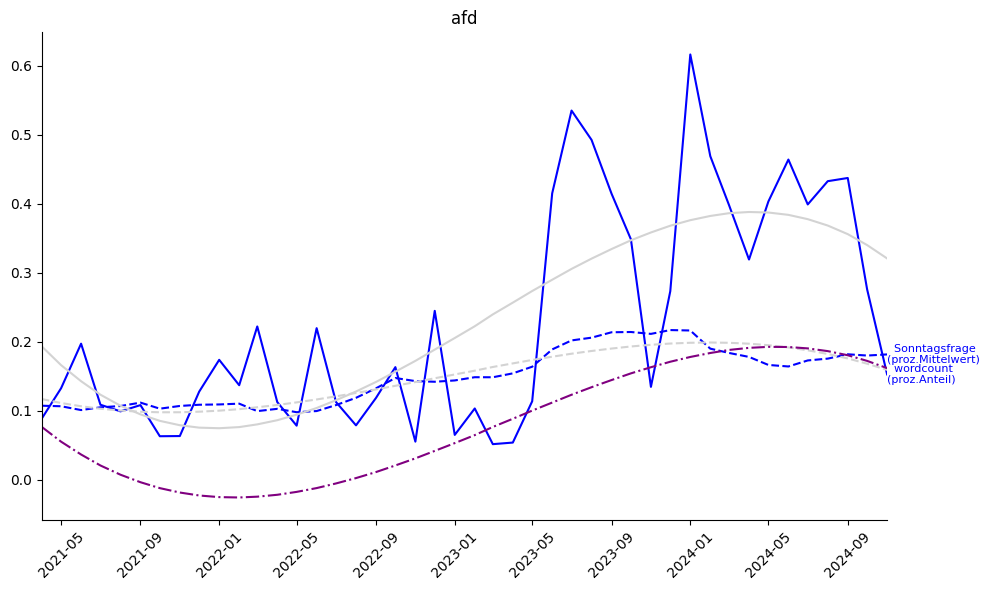

In [56]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Liste der Parteien
parteien = ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']

# Für jede Partei ein separates Diagramm erstellen
for partei in parteien:
    plt.figure(figsize=(10, 6))
    

    # Durchgezogene Linie (monthly_data)
    plt.plot(
        monthly_data_wide["year_month"], 
        monthly_data_wide[partei], 
        label='wordcount', 
        color=farben.get(partei, "gray")
    )
    # Beschriftung am Ende der Linie hinzufügen (monthly_data)
    plt.text(
        monthly_data_wide["year_month"].iloc[-1],  # Letzter x-Wert
        monthly_data_wide[partei].iloc[-1],      # Letzter y-Wert
        f'  wordcount\n(proz.Anteil)',               # Beschriftung mit Leerzeichen für Abstand
        color=farben.get(partei, "gray"),            # Textfarbe entsprechend der Linie
        fontsize=8,                                 # Schriftgröße
        va='center'                                  # Vertikale Ausrichtung
    )
    
    # Gestrichelte Linie (df_aggregiert)
    plt.plot(
        df_aggregiert['datum'], 
        df_aggregiert[partei], 
        label='Sonntagsfrage', 
        color=farben.get(partei, "gray"), 
        linestyle='--', 
        #alpha=0.5
    )
    # Beschriftung am Ende der Linie hinzufügen (df_aggregiert)
    plt.text(
        df_aggregiert['datum'].iloc[-1],  # Letzter x-Wert
        df_aggregiert[partei].iloc[-1],   # Letzter y-Wert
        f'  Sonntagsfrage\n(proz.Mittelwert)', # Beschriftung mit Leerzeichen für Abstand
        color=farben.get(partei, "gray"), # Textfarbe entsprechend der Linie
        fontsize=8,                      # Schriftgröße
        va='center'                       # Vertikale Ausrichtung
    )

    # Trendlinie hinzufügen wordcount
    if not monthly_data_wide.empty:
        # Konvertiere year_month in Zahlen für die Regression
        x = np.arange(len(monthly_data_wide["year_month"]))
        y = monthly_data_wide[partei].values
        
        # Lineare Regression berechnen
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        
        # Trendlinie plotten
        plt.plot(
            monthly_data_wide["year_month"], 
            p(x), 
            color= 'lightgray', 
            linestyle='-'
        )

    # Trendlinie hinzufügen Sonntagsfrage
    if not df_aggregiert.empty:
        # Konvertiere datum in Zahlen für die Regression
        x_agg = np.arange(len(df_aggregiert["datum"]))
        y_agg = df_aggregiert[partei].values
        
        # Lineare Regression berechnen
        z_agg = np.polyfit(x_agg, y_agg, 3)
        p_agg = np.poly1d(z_agg)
        
        # Trendlinie plotten
        plt.plot(
            df_aggregiert["datum"], 
            p_agg(x_agg), 
            color= 'lightgray', 
            linestyle='--'
        )
     # Differenz der beiden Trendlinien
    if not monthly_data_wide.empty and not df_aggregiert.empty:
        # Differenz zwischen den Trendlinien (Polynom-Modelle)
        trend_diff = p(x) - p_agg(x_agg)
        
        # Plotten der Differenz
        plt.plot(
            monthly_data_wide["year_month"], 
            trend_diff, 
            label=f'Differenz der Trends: {partei}', 
            color='purple', 
            linestyle='-.'
        )
    
    plt.title(f'{partei}')
    plt.xlabel('')
    plt.ylabel('')
    
    # Bereich der x-Achse festlegen
    plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])
    
    # X-Achse drehen, um Monatsnamen leserlich anzuzeigen
    plt.xticks(rotation=45)
    
    # Rahmenlinien oben und rechts entfernen
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


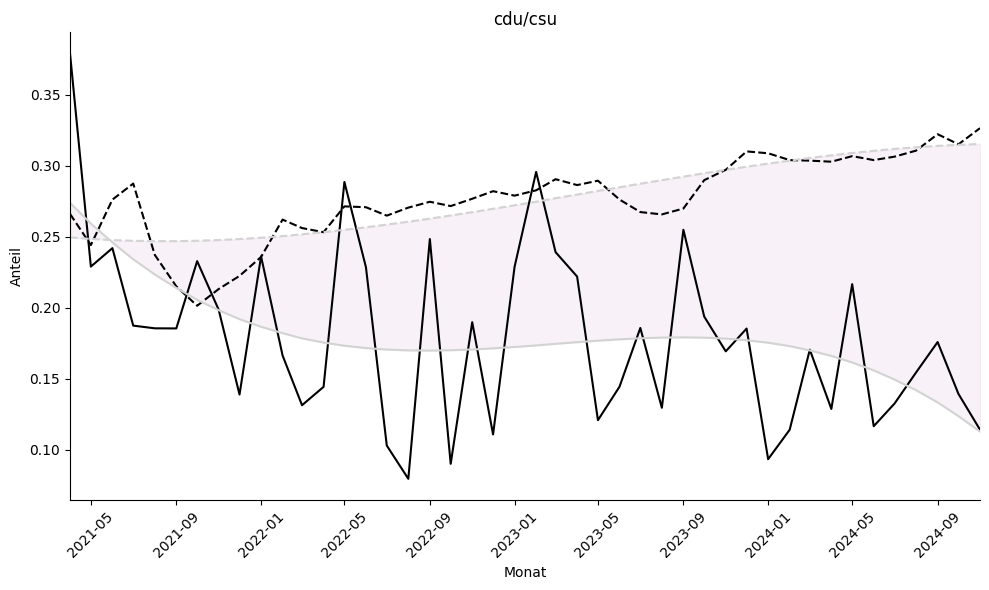

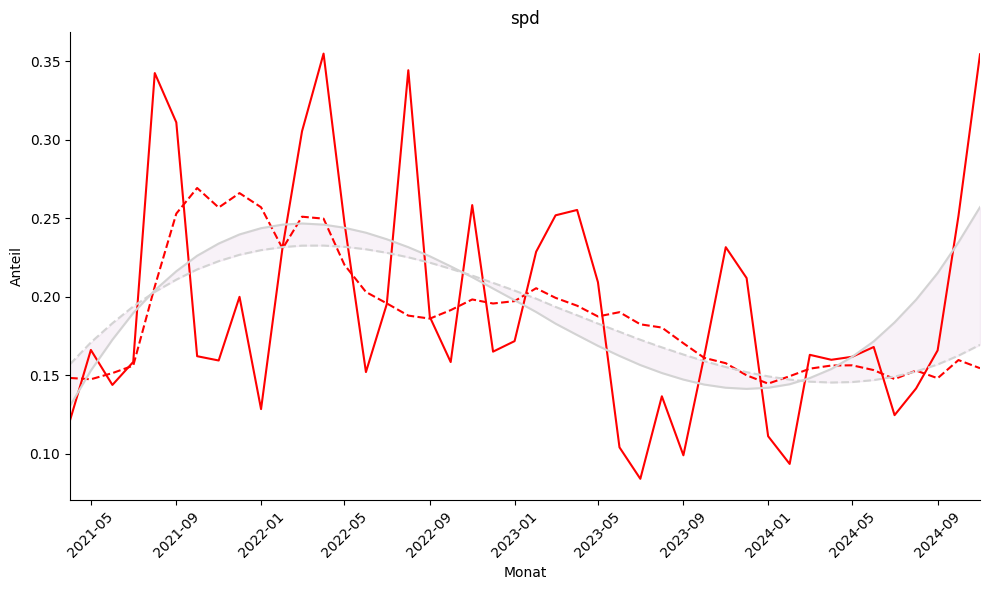

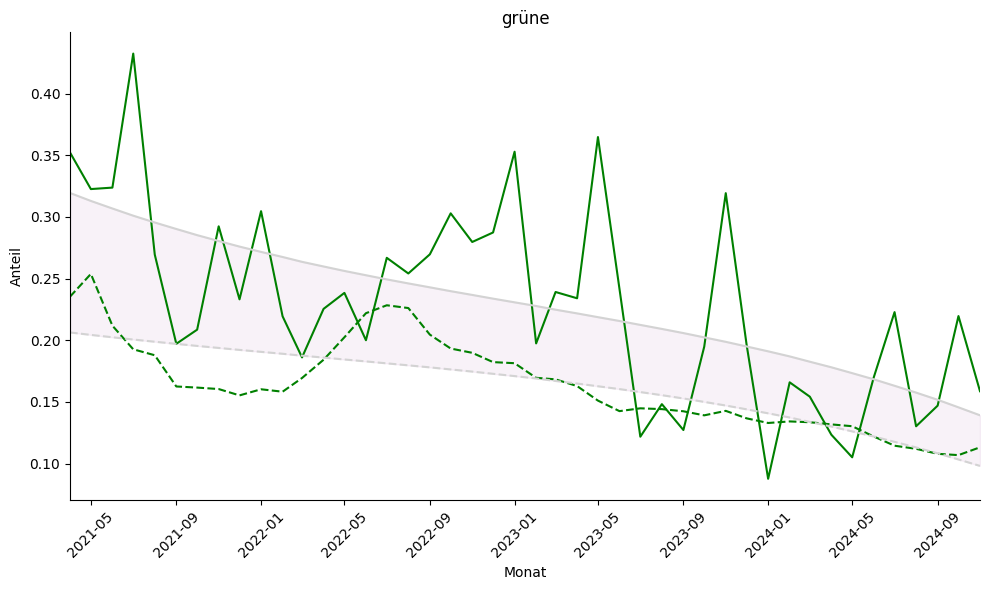

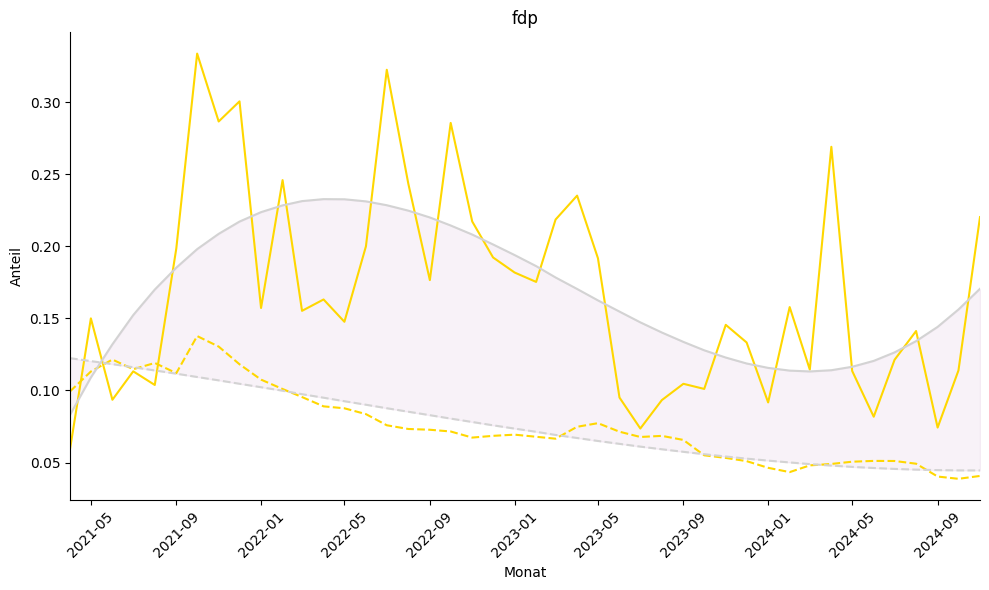

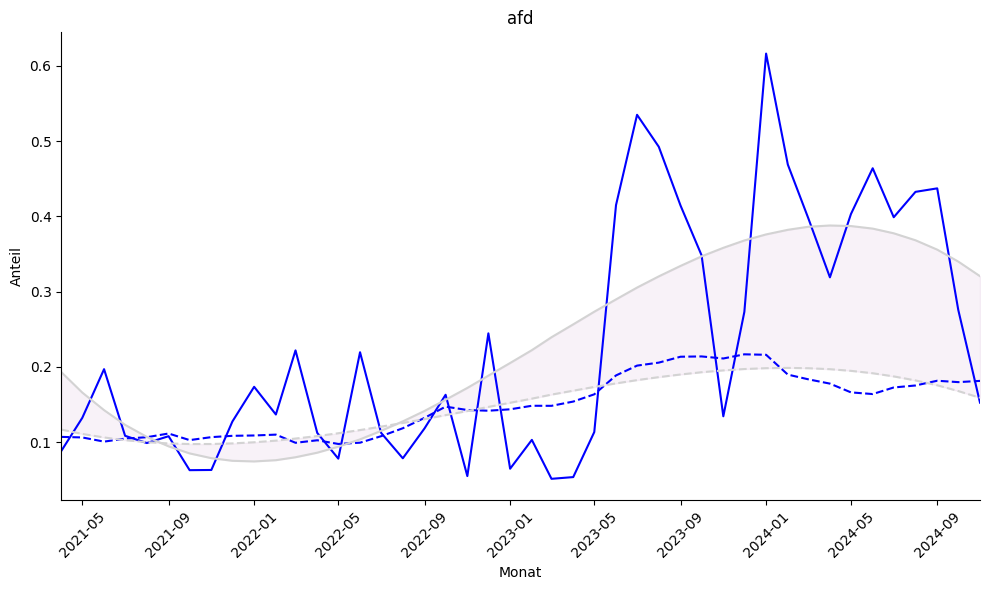

In [57]:
# Farben für die Parteien festlegen
farben = {
    'cdu/csu': 'black',
    'spd': 'red',
    'grüne': 'green',
    'fdp': 'gold',
    'afd': 'blue'
}

# Liste der Parteien
parteien = ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']

# Für jede Partei ein separates Diagramm erstellen
for partei in parteien:
    plt.figure(figsize=(10, 6))
    
    # Durchgezogene Linie (monthly_data)
    plt.plot(
        monthly_data_wide["year_month"], 
        monthly_data_wide[partei], 
        label='wordcount', 
        color=farben.get(partei, "gray")
    )

    # Gestrichelte Linie (df_aggregiert)
    plt.plot(
        df_aggregiert['datum'], 
        df_aggregiert[partei], 
        label='Sonntagsfrage', 
        color=farben.get(partei, "gray"), 
        linestyle='--'
    )

    # Trendlinie für wordcount
    if not monthly_data_wide.empty:
        x = np.arange(len(monthly_data_wide["year_month"]))
        y = monthly_data_wide[partei].values
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        plt.plot(
            monthly_data_wide["year_month"], 
            p(x), 
            color='lightgray', 
            linestyle='-'
        )

    # Trendlinie für Sonntagsfrage
    if not df_aggregiert.empty:
        x_agg = np.arange(len(df_aggregiert["datum"]))
        y_agg = df_aggregiert[partei].values
        z_agg = np.polyfit(x_agg, y_agg, 3)
        p_agg = np.poly1d(z_agg)
        plt.plot(
            df_aggregiert["datum"], 
            p_agg(x_agg), 
            color='lightgray', 
            linestyle='--'
        )

    # Fläche zwischen den Trendlinien einfärben
    if not monthly_data_wide.empty and not df_aggregiert.empty:
        plt.fill_between(
            monthly_data_wide["year_month"], 
            p(x), 
            p_agg(x_agg), 
            color='purple', 
            alpha=0.05,  # Transparenz
            label=f'Fläche zwischen den Trends: {partei}'
        )

    # Diagrammtitel und Achsentitel für das Trendlinien-Diagramm
    plt.title(f'{partei}')
    plt.xlabel('Monat')
    plt.ylabel('Anteil')
    plt.xticks(rotation=45)

    # Bereich der x-Achse festlegen
    plt.xlim(df_aggregiert['datum'].iloc[0], df_aggregiert['datum'].iloc[-1])

    # Rahmenlinien oben und rechts entfernen
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


In [58]:
# Liste der Parteien
parteien = ['cdu/csu', 'spd', 'grüne', 'fdp', 'afd']

for partei in parteien:
    
    # Differenz zwischen den Trendlinien
    if not monthly_data_wide.empty and not df_aggregiert.empty:
        # Trendlinien für monthly_data_wide
        x = np.arange(len(monthly_data_wide["year_month"]))
        y = monthly_data_wide[partei].values
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        
        # Trendlinien für df_aggregiert
        x_agg = np.arange(len(df_aggregiert["datum"]))
        y_agg = df_aggregiert[partei].values
        z_agg = np.polyfit(x_agg, y_agg, 3)
        p_agg = np.poly1d(z_agg)

        # Differenz der beiden Trendlinien
        trend_diff = p(x) - p_agg(x_agg)

        #Durchschnitt
        mean_diff = (np.mean(trend_diff)*100).round(2)
        print(f'Durchschnittliche Differenz der Trends für {partei}: {mean_diff}')

Durchschnittliche Differenz der Trends für cdu/csu: -9.65
Durchschnittliche Differenz der Trends für spd: 0.59
Durchschnittliche Differenz der Trends für grüne: 6.55
Durchschnittliche Differenz der Trends für fdp: 9.18
Durchschnittliche Differenz der Trends für afd: 7.96


### export

In [59]:
#df.to_sql("politics_1", con = con, if_exists = "replace")

In [60]:
#monthly_data.to_sql("politics_2", con=con, if_exists = "replace")

In [61]:
#df_gesamt.to_sql("polls_1", con = con, if_exists = "replace")

In [62]:
#df_aggregiert.to_sql("polls_2", con = con, if_exists = "replace")